# Needed libraries

In [1]:
import numpy as np
import os
from sklearn import preprocessing
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sys
from scipy.stats import binned_statistic_2d
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc
thismodule = sys.modules[__name__]

from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
from read_lhco import read_lhco

In [3]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.lines as mlines
from xgboost import XGBRegressor, XGBClassifier
from scipy.interpolate import bisplrep,bisplev

In [4]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [5]:
import numpy as np
from scipy.optimize import fsolve

def equation(mu, pb_ps, S, B):
    return np.sum(1 / (mu * S + B * pb_ps)) - 1

def find_mu(pb_ps, S, B, mu_guess=1.0):
    mu_solution = fsolve(equation, mu_guess, args=(pb_ps, S, B))
    return mu_solution[0]


In [6]:
BPs2plot = [0,1,2,3,4,5,6,7] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [7]:

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Signal events

In [8]:
signal_NLO  = 1.25
luminosidad = 100

cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_x01_w_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])
branching_ratios_x02_x01_bps = np.asarray([0.70 , 0.50 , 0.40 , 0.73 , 0.47, 0.71, 0.44, 0.72])
branching_ratios_x03_x02_bps = np.asarray([0.89 , 0.89 , 0.91 , 0.92 , 0.84, 0.91, 0.90, 0.92])

signal_cross = cross_section_bps * branching_ratios_x01_w_bps * branching_ratios_x02_x01_bps *  0.2134 # fb. 0.2134 is the branching ratios W a ligh leptons

fid_cross_sections = np.zeros(len(cross_section_bps))
expected_events = np.zeros(len(cross_section_bps))
sim_events = np.zeros(len(cross_section_bps))
cut_events = np.zeros(len(cross_section_bps))

In [17]:
!ls ../data/BP1_1/

pptox1n2j_nmssm  pptox1n3j_nmssm


In [19]:
write = False
MET_cut = 100

#bp_number = 1

for bp_number in ['1_1']:

    signal_cut_ev  = 0
    signal_init_ev = 0

    counter_bad_jets = 0
    contador_tau     = 0
    signal_runs = os.listdir(f'../data/BP{bp_number}/pptox1n3j_nmssm')
    signal_runs = [file for file in signal_runs if file.endswith(".lhco")] # To keep only .lhco files

    for ii, file in enumerate(signal_runs):
        print(ii)
        inputevents = read_lhco(f'../data/BP{bp_number}/pptox1n3j_nmssm/' + file, OutputType = 'dict')
        signal_init_ev += len(inputevents)
        print('Esta run tuvo ' + str(len(inputevents)) + ' eventos en el lhco')
        
        for i in range(len(inputevents)):
    
            # at least one: photon, jet and lepton (electron or muon)
            if len(inputevents[i]["photon"]) > 0 and len(inputevents[i]["jet"]) > 0 and (len(inputevents[i]["electron"]) > 0 or len(inputevents[i]["muon"]) > 0):
                if inputevents[i]["jet"][0]["pt"] > 100 and -4.5 < inputevents[i]["jet"][0]["eta"] < 4.5:
                    if inputevents[i]["photon"][0]["pt"] > 10 and -2.37 < inputevents[i]["photon"][0]["eta"] < 2.37:
                        if inputevents[i]["met"][0]["pt"] > MET_cut:
    
                            # lepton info
                            if (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) > 0):
                                if inputevents[i]["electron"][0]["pt"] > inputevents[i]["muon"][0]["pt"]: 
                                    flag = 'electron'
                                    eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                                else: 
                                    flag = 'muon'
                                    eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
                            elif (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) == 0): 
                                flag = 'electron'
                                eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                            elif (len(inputevents[i]["muon"]) > 0) and (len(inputevents[i]["electron"]) == 0): 
                                flag = 'muon'
                                eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
    
                            if (-2.47 < eta_leading_lepton < -1.52) or (-1.37 < eta_leading_lepton < 1.37) or (1.52 < eta_leading_lepton < 2.47): 
    
                                # how many jets (total) and total hadronic pT
                                flag_bad_jets = 0                            
                                num_jets = 0
                                HT_had = 0 # hadronic activity HT, defined as the scalar sum of the pT of all reconstructed jets
                                HT = 0 # total HT, defined as the scalar sum of the pT of all reconstructed particles
    
                                for j in range(len(inputevents[i]["jet"])):
                                    if (inputevents[i]["jet"][j]["pt"] > 20) and (-4.5 < inputevents[i]["jet"][j]["eta"] < 4.5):
                                        num_jets += 1
                                        HT_had += inputevents[i]["jet"][j]["pt"]
                                        HT += inputevents[i]["jet"][j]["pt"]
                                    if (np.abs(inputevents[i]["jet"][j]["eta"]) > 4.5) or (inputevents[i]["jet"][j]["pt"] < 20):
                                        flag_bad_jets = 1
    
                                # how many photons                         
                                num_photons = 0
                                for j in range(len(inputevents[i]["photon"])):
                                    if inputevents[i]["photon"][j]["pt"] > 10 and -2.37 < inputevents[i]["photon"][j]["eta"] < 2.37:
                                        num_photons = num_photons + 1
                                        HT += inputevents[i]["photon"][j]["pt"]
    
                                # how many muons                        
                                num_muons = 0
                                for j in range(len(inputevents[i]["muon"])):
                                    if inputevents[i]["muon"][j]["pt"] > 10 and -2.7 < inputevents[i]["muon"][j]["eta"] < 2.7:
                                        num_muons = num_muons + 1
                                        HT += inputevents[i]["muon"][j]["pt"]
    
                                # how many electrons                        
                                num_electrons = 0
                                for j in range(len(inputevents[i]["electron"])):
                                    if inputevents[i]["electron"][j]["pt"] > 10:
                                        eta = inputevents[i]["electron"][j]["eta"]
                                        if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                            num_electrons = num_electrons + 1
                                            HT += inputevents[i]["electron"][j]["pt"]
    
                                if flag_bad_jets == 1: counter_bad_jets += 1 
                                if flag_bad_jets == 0:
                                    num_taus = 0
                                    if len(inputevents[i]["tau"]) > 0: 
                                        contador_tau = contador_tau + 1
                                        # how many taus                    
                                        for j in range(len(inputevents[i]["tau"])):
                                            if inputevents[i]["tau"][j]["pt"] > 20:
                                                eta = inputevents[i]["tau"][j]["eta"]
                                                if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                                    num_taus = num_taus + 1
                                                    HT += inputevents[i]["tau"][j]["pt"]
    
                                    if write:                
                                        # photon info:
                                        with open(f'../data/BP{bp_number}/photon_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %f %d\n' % (inputevents[i]["photon"][0]["pt"],inputevents[i]["photon"][0]["eta"],inputevents[i]["photon"][0]["phi"], num_photons))
    
                                        # jet info:
                                        with open(f'../data/BP{bp_number}/jet_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["jet"][0]["pt"],inputevents[i]["jet"][0]["eta"],inputevents[i]["jet"][0]["phi"]))
    
                                        # lepton info
                                        num_leptons = num_electrons + num_muons
                                        if flag == 'electron':
                                            with open(f'../data/BP{bp_number}/lepton_MET_cut.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["electron"][0]["pt"],inputevents[i]["electron"][0]["eta"],inputevents[i]["electron"][0]["phi"], num_leptons, num_taus))
                                        else:
                                            with open(f'../data/BP{bp_number}/lepton_MET_cut.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["muon"][0]["pt"],inputevents[i]["muon"][0]["eta"],inputevents[i]["muon"][0]["phi"], num_leptons, num_taus))
    
                                        # MET (eta=0 by def, but I save phi because I have many jets)
                                        with open(f'../data/BP{bp_number}/MET_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["met"][0]["pt"],inputevents[i]["met"][0]["eta"],inputevents[i]["met"][0]["phi"]))
    
                                        # hadronic info
                                        with open(f'../data/BP{bp_number}/hadinfo_MET_cut.dat', 'a') as f:
                                            f.write('%f %f %d\n' % (HT, HT_had, num_jets))
    
                                    # total events that passed the cuts
                                    signal_cut_ev += 1
    
    print('Num initial events: ', signal_init_ev)
    print('Total pasaron los cortes: ', signal_cut_ev)
    print('Hay: ', contador_tau, ' taus')
    print('Hay: ', counter_bad_jets, ' eventos con al menos un jet malo')
    
    
    cross       = signal_cross[bp_number-1] * signal_NLO
    aceptancia  = signal_cut_ev / signal_init_ev
    
    signal_fidcross = cross * aceptancia
    signal_expected = cross * aceptancia * luminosidad
    
    fid_cross_sections[bp_number - 1] = signal_fidcross
    expected_events[bp_number - 1] = signal_expected
    sim_events[bp_number - 1] = signal_init_ev
    cut_events[bp_number - 1] = signal_cut_ev
    print('fiducial cross section: ', signal_fidcross)
    print('Events expected: ', signal_expected)

0
Esta run tuvo 100000 eventos en el lhco
1
Esta run tuvo 100000 eventos en el lhco
2
Esta run tuvo 100000 eventos en el lhco
3
Esta run tuvo 100000 eventos en el lhco
4
Esta run tuvo 100000 eventos en el lhco
5
Esta run tuvo 100000 eventos en el lhco
6
Esta run tuvo 100000 eventos en el lhco
7
Esta run tuvo 100000 eventos en el lhco
8
Esta run tuvo 100000 eventos en el lhco
9
Esta run tuvo 100000 eventos en el lhco
Num initial events:  1000000
Total pasaron los cortes:  86660
Hay:  1195  taus
Hay:  831  eventos con al menos un jet malo


TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [ ]:
print('Fid cross sections: ', fid_cross_sections)
print('Expected events: ', expected_events)
print('Simulated events: ', sim_events)
print('Number of events after cuts: ', cut_events)

# Analysis (MET > 100)

## Reading SM data

In [8]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

wgamma_cross = 0.944 * 1000 #[fb]
wgamma_NLO   = 2.37 # k-factor [14 TeV]

wjets_cross = 168.12 * 1000 #[fb]
wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [9]:
wgamma_fidcross  = 584.6234
wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

bkg = ['wgamma', 'wjets', 'ttgamma',
       'zjets',
       'ttjets',
       'tj', 'tb', 'tw',
       'ww', 'zz', 'wz'
      ]

B_fidcross_tot = 0
for i, ibkg in enumerate(bkg):
    B_fidcross_tot = B_fidcross_tot + globals()[ibkg + '_fidcross']
B_fidcross_tot

1479.8648040000003

In [10]:
wgamma_aceptancia_init  = wgamma_fidcross / (wgamma_cross * wgamma_NLO)
wjets_aceptancia_init   = wjets_fidcross / (wjets_cross * wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [11]:
wgamma_expected  = 58462.34
wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = 0
for i, ibkg in enumerate(bkg):
    B_expected = B_expected + globals()[ibkg + '_expected']
B_expected

147986.4804

In [12]:
sample = 200_000 # Number of signal and background events to train and validate

wgamma_sample  = int(round(sample * wgamma_fidcross / B_fidcross_tot))
wjets_sample   = int(round(sample * wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(wgamma_sample)
print(wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [13]:
datFolderwgamma  = '../../susyatLHC/data/Wgamma/'
datFolderwjets   = '../../susyatLHC/data/Wjets/'
datFolderttgamma = '../../susyatLHC/data/ttGamma/'
datFolderttjets  = '../../susyatLHC/data/ttjets/'
datFolderzjets   = '../../susyatLHC/data/Zlep+j/'
datFolderwz      = '../../susyatLHC/data/wz/'
datFolderww      = '../../susyatLHC/data/ww/'
datFolderzz      = '../../susyatLHC/data/zz/'
datFoldertj      = '../../susyatLHC/data/singleTop+j/'
datFoldertb      = '../../susyatLHC/data/singleTop+b/'
datFoldertw      = '../../susyatLHC/data/singleTop+W/'

for i, ibkg in enumerate(bkg):
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'photon_4.dat', delimiter=' ')
    setattr(thismodule, 'photon_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'jet_4.dat', delimiter=' ')
    setattr(thismodule, 'jet_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'lepton_4.dat', delimiter=' ')
    setattr(thismodule, 'lepton_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'MET_4.dat', delimiter=' ')
    setattr(thismodule, 'MET_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'hadinfo_4.dat', delimiter=' ')
    setattr(thismodule, 'hadinfo_' + ibkg, aux)

In [14]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM  = globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]
        jet_SM     = globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]
        lepton_SM  = globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]
        MET_SM     = globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]
        hadinfo_SM = globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]
    else:
        photon_SM  = np.concatenate([photon_SM, globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]])
        jet_SM     = np.concatenate([jet_SM, globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]])
        lepton_SM  = np.concatenate([lepton_SM, globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]])
        MET_SM     = np.concatenate([MET_SM, globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]])
        hadinfo_SM = np.concatenate([hadinfo_SM, globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]])

In [15]:
bkg_flag = np.zeros(len(photon_SM))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag[:globals()[ibkg + '_sample']] = i + 1
        end_ind = globals()[ibkg + '_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_sample']
        bkg_flag[(init_ind):(end_ind)] = i + 1

In [16]:
wjets_pool  = len(photon_wjets[wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / wjets_fidcross)

wgamma_pool_sample  = int(round(pool_sample * wgamma_fidcross / B_fidcross_tot))
wjets_pool_sample   = int(round(pool_sample * wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(wgamma_pool_sample)
print(wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [17]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM_pool  = globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        jet_SM_pool     = globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        lepton_SM_pool  = globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        MET_SM_pool     = globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        hadinfo_SM_pool = globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
    else:
        photon_SM_pool  = np.concatenate([photon_SM_pool, globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        jet_SM_pool     = np.concatenate([jet_SM_pool, globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        lepton_SM_pool  = np.concatenate([lepton_SM_pool, globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        MET_SM_pool     = np.concatenate([MET_SM_pool, globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        hadinfo_SM_pool = np.concatenate([hadinfo_SM_pool, globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])

In [18]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag_pool[:globals()[ibkg + '_pool_sample']] = i + 1
        end_ind = globals()[ibkg + '_pool_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_pool_sample']
        bkg_flag_pool[(init_ind):(end_ind)] = i + 1

In [19]:
print(photon_wjets.shape)
print(photon_ttgamma.shape)
print(photon_wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [20]:
for i, ibkg in enumerate(bkg):
    aux = globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'ST_' + ibkg, aux)
    
    aux = np.divide( globals()['MET_' + ibkg][:,0], np.sqrt(globals()['hadinfo_' + ibkg][:,0]) )
    setattr(thismodule, 'MET_sig_' + ibkg, aux)
    
    aux = globals()['MET_' + ibkg][:,0] + globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'm_eff_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['photon_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_photon_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_jet_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['photon_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_photon_' + ibkg])) )
    setattr(thismodule, 'mT_photon_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['jet_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_jet_' + ibkg])) )
    setattr(thismodule, 'mT_jet_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['lepton_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_lepton_' + ibkg])) )
    setattr(thismodule, 'mT_lepton_' + ibkg, aux)
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_jet_' + ibkg, aux)    
    globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi]
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_lepton_' + ibkg, aux)    
    globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi]
        
    aux = np.absolute( globals()['lepton_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_lepton_jet_' + ibkg, aux)    
    globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi]
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_photon_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_jet_' + ibkg, aux)  
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['lepton_' + ibkg][:,1])**2 + (globals()['phi_photon_lepton_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (globals()['lepton_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_lepton_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_lepton_jet_' + ibkg, aux)

In [21]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [22]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## Reading NP data

In [23]:
datFolderNP = '../data/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/photon_100.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/jet_100.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/lepton_100.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/MET_100.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/hadinfo_100.dat', delimiter=' ') )

In [24]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1 (257030, 5)
BP2 (279473, 5)
BP3 (279659, 5)
BP4 (279491, 5)
BP5 (374847, 5)
BP6 (372682, 5)
BP7 (317450, 5)
BP8 (344465, 5)


In [25]:
jet_NP[7].shape

(344465, 3)

In [26]:
signal_NLO  = 1.25
luminosidad = 100


cross_section_bps            = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_x01_w_bps   = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])
branching_ratios_x02_x01_bps = np.asarray([0.70 , 0.50 , 0.40 , 0.73 , 0.47, 0.71, 0.44, 0.72])
branching_ratios_x03_x02_bps = np.asarray([0.89 , 0.89 , 0.91 , 0.92 , 0.84, 0.91, 0.90, 0.92])

signal_cross = cross_section_bps * branching_ratios_x01_w_bps * branching_ratios_x02_x01_bps *  0.2134 # fb

sim_events = np.asarray([1_900_000., 2_300_000., 2_500_000., 2_000_000., 2_597_448., 2_398_994., 2_300_000., 2_100_000.])
cut_events = np.asarray([257_030.  , 279_473.  , 279_659.  , 279_491.  , 374_847.  , 372_682.  , 317_450.  , 344_465.])

cross       = signal_cross * signal_NLO
aceptancia  = cut_events / sim_events
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [4.49101907 2.91138185 1.11558386 2.16051991 0.83363283 1.36988782
 0.40810061 0.77675732]
Events expected:  [449.10190657 291.13818479 111.55838576 216.05199115  83.36328259
 136.98878196  40.81006135  77.67573159]


In [27]:
S_expected

array([449.10190657, 291.13818479, 111.55838576, 216.05199115,
        83.36328259, 136.98878196,  40.81006135,  77.67573159])

In [28]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

## Plots

In [26]:
BPs2plot = [0,1,2,3,4,5,6,7] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [30]:
sm_color = (1.0, 0.498, 0.314)
wjets_color = 'gray'
wgamma_color = 'gray'
ttgamma_color = 'gray'
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')

In [31]:
bkg_labels = ['W + jets', '$W \ \\gamma$', '$t \\bar{t}$ + jets', 'Z + jets', 'Single-top', '$t \\bar{t} \ \\gamma$', 'Diboson']
cmap = plt.cm.get_cmap('Reds', 8)
colors = [mpl.colors.to_hex(cmap(i+1)) for i in range(len(bkg_labels))]
cmap = cm.get_cmap('Blues', 18)

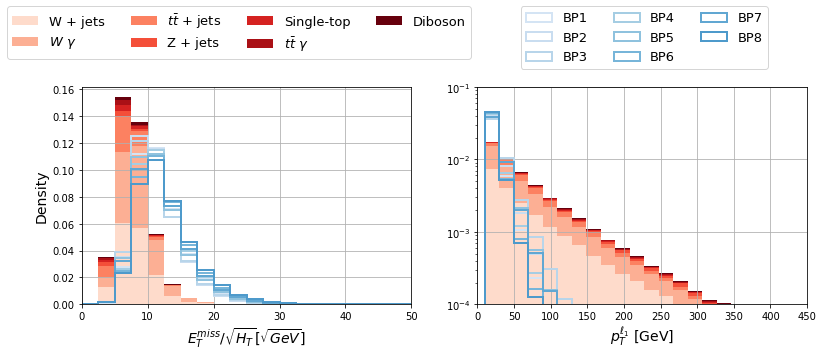

In [37]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# MET sig -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20 
bin_range = [0,50]

bkg_list = [MET_sig_wjets[:wjets_sample], MET_sig_wgamma[:wgamma_sample], MET_sig_ttjets[:ttjets_sample],
            MET_sig_zjets[:zjets_sample], 
            np.concatenate((MET_sig_tj[:tj_sample], MET_sig_tb[:tb_sample], MET_sig_tw[:tw_sample])), 
            MET_sig_ttgamma[:ttgamma_sample], 
            np.concatenate((MET_sig_zz[:zz_sample], MET_sig_wz[:wz_sample], MET_sig_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.20, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(MET_sig_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss} / \sqrt{H_{T}} [\sqrt{GeV}]$",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
#ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,50)
#ax[ncol].set_ylim(5e-5,1)

# Pt lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins  = 50
bin_range = [10,1000]

bkg_list = [lepton_wjets[:wjets_sample,0], lepton_wgamma[:wgamma_sample,0], lepton_ttjets[:ttjets_sample,0],
            lepton_zjets[:zjets_sample,0],
            np.concatenate((lepton_tj[:tj_sample,0], lepton_tb[:tb_sample,0], lepton_tw[:tw_sample,0])), 
            lepton_ttgamma[:ttgamma_sample,0], 
            np.concatenate((lepton_zz[:zz_sample,0], lepton_wz[:wz_sample,0], lepton_ww[:ww_sample,0]))]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)


for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.9, 1.4), ncol = 3)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,0.1)
ax[ncol].set_xlim(0,450)

plt.savefig('../graph/MET_sig_PT_lepton_dist.pdf', bbox_inches='tight')

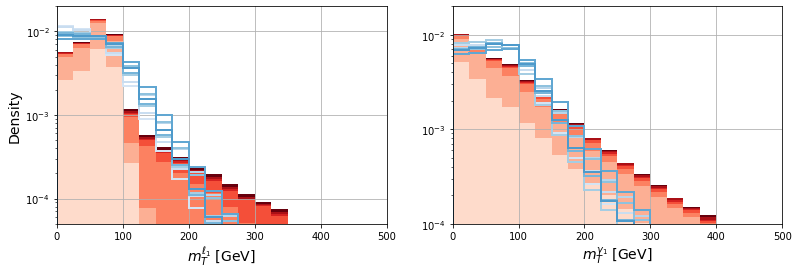

In [38]:
fig,ax = plt.subplots(1,2, figsize = (13,4))


# Mt lepton info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20
bin_range = [0,500]

bkg_list = [mT_lepton_wjets[:wjets_sample], mT_lepton_wgamma[:wgamma_sample], mT_lepton_ttjets[:ttjets_sample],
            mT_lepton_zjets[:zjets_sample], 
            np.concatenate((mT_lepton_tj[:tj_sample], mT_lepton_tb[:tb_sample], mT_lepton_tw[:tw_sample])),
            mT_lepton_ttgamma[:ttgamma_sample],
            np.concatenate((mT_lepton_zz[:zz_sample], mT_lepton_wz[:wz_sample], mT_lepton_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
#ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.35, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(mT_lepton_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,500)
ax[ncol].set_ylim(5e-5,2e-2)
ax[ncol].set_ylabel("Density",fontsize=14)

# Mt photon
ncol = 1
nbins = 20
bin_range = [0,500]

bkg_list = [mT_photon_wjets[:wjets_sample], mT_photon_wgamma[:wgamma_sample], mT_photon_ttjets[:ttjets_sample],
            mT_photon_zjets[:zjets_sample], 
            np.concatenate((mT_photon_tj[:tj_sample], mT_photon_tb[:tb_sample], mT_photon_tw[:tw_sample])),
            mT_photon_ttgamma[:ttgamma_sample],
            np.concatenate((mT_photon_zz[:zz_sample], mT_photon_wz[:wz_sample], mT_photon_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_photon_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
#ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1., 1.4), ncol = 3)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,2e-2)
ax[ncol].set_xlim(0,500)

plt.savefig('../graph/mt_lepton_mt_photon.pdf', bbox_inches='tight')

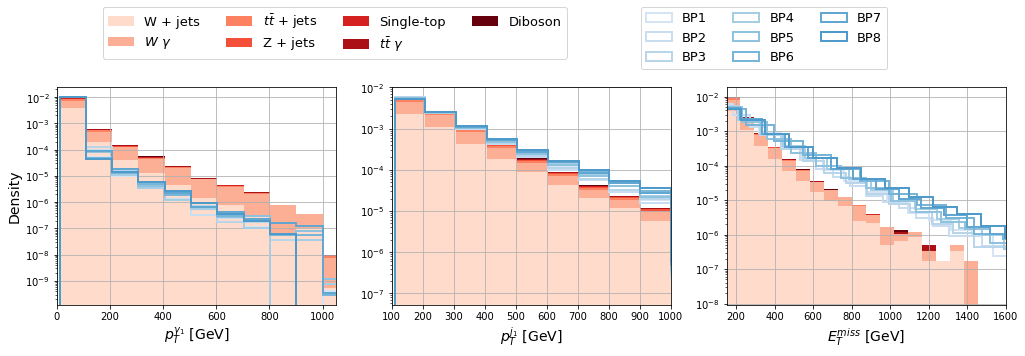

In [39]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# Pt Photon -----------------------------------------------------------------------------------------------------------------------
ncol  = 0
nbins = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [photon_wjets[:wjets_sample,0], photon_wgamma[:wgamma_sample,0], photon_ttjets[:ttjets_sample,0], 
            photon_zjets[:zjets_sample,0], 
            np.concatenate((photon_tj[:tj_sample,0], photon_tb[:tb_sample,0], photon_tw[:tw_sample,0])),
            photon_ttgamma[:ttgamma_sample,0], 
            np.concatenate((photon_zz[:zz_sample,0],photon_wz[:wz_sample,0],photon_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.85, 1.4), ncol = 4) 


for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,1050)
ax[ncol].set_ylabel("Density",fontsize=14)


# Pt jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.array([109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [jet_wjets[:wjets_sample,0], jet_wgamma[:wgamma_sample,0], jet_ttjets[:ttjets_sample,0], 
            jet_zjets[:zjets_sample,0], 
            np.concatenate((jet_tj[:tj_sample,0], jet_tb[:tb_sample,0], jet_tw[:tw_sample,0])),
            jet_ttgamma[:ttgamma_sample,0],
            np.concatenate((jet_zz[:zz_sample,0],jet_wz[:wz_sample,0],jet_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.8, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(100,1000)



# Pt MET -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 20
bin_range = [150,1600]

bkg_list = [MET_wjets[:wjets_sample,0], MET_wgamma[:wgamma_sample,0], MET_ttjets[:ttjets_sample,0], 
            MET_zjets[:zjets_sample,0], 
            np.concatenate((MET_tj[:tj_sample,0], MET_tb[:tb_sample,0], MET_tw[:tw_sample,0])),
            MET_ttgamma[:ttgamma_sample,0],
            np.concatenate((MET_zz[:zz_sample,0],MET_wz[:wz_sample,0],MET_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(MET_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(150,1600)

plt.savefig('../graph/PT_photon_PT_jet_ETmiss.pdf', bbox_inches='tight')

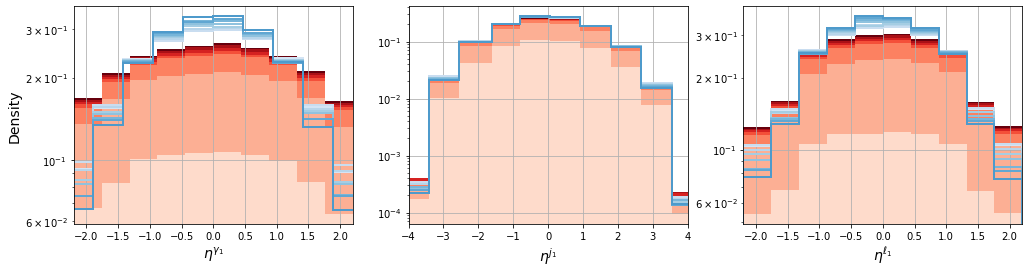

In [40]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# eta Photon -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [photon_wjets[:wjets_sample,1], photon_wgamma[:wgamma_sample,1], photon_ttjets[:ttjets_sample,1],
            photon_zjets[:zjets_sample,1], 
            np.concatenate((photon_tj[:tj_sample,1], photon_tb[:tb_sample,1], photon_tw[:tw_sample,1])),
            photon_ttgamma[:ttgamma_sample,1],
            np.concatenate((photon_zz[:zz_sample,1],photon_wz[:wz_sample,1],photon_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)
ax[ncol].set_ylabel("Density",fontsize=14)


# eta jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.asarray([-8.3 , -3.42, -2.55, -1.62, -0.80, 0.063 , 0.93, 1.80, 2.68, 3.55, 8.42])

bkg_list = [jet_wjets[:wjets_sample,1], jet_wgamma[:wgamma_sample,1], jet_ttjets[:ttjets_sample,1],
            jet_zjets[:zjets_sample,1], 
            np.concatenate((jet_tj[:tj_sample,1], jet_tb[:tb_sample,1], jet_tw[:tw_sample,1])),
            jet_ttgamma[:ttgamma_sample,1], 
            np.concatenate((jet_zz[:zz_sample,1],jet_wz[:wz_sample,1],jet_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{j_{1}}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-4.,4.)


# eta lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [lepton_wjets[:wjets_sample,1], lepton_wgamma[:wgamma_sample,1], lepton_ttjets[:ttjets_sample,1],
            lepton_zjets[:zjets_sample,1], 
            np.concatenate((lepton_tj[:tj_sample,1], lepton_tb[:tb_sample,1], lepton_tw[:tw_sample,1])),
            lepton_ttgamma[:ttgamma_sample,1],
            np.concatenate((lepton_zz[:zz_sample,1],lepton_wz[:wz_sample,1],lepton_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\ell_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)

plt.savefig('../graph/eta_photon_lepton_jet_dist.pdf', bbox_inches='tight')

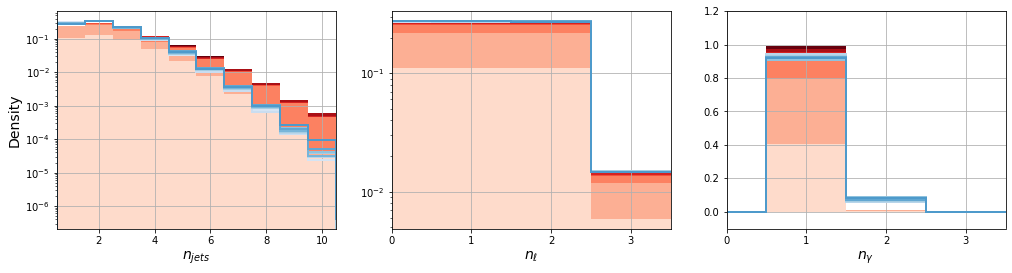

In [41]:
fig,ax = plt.subplots(1,3, figsize = (17,4))


# Num jets
ncol = 0
nbins = np.asarray([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,25])

bkg_list = [hadinfo_wjets[:wjets_sample,2], hadinfo_wgamma[:wgamma_sample,2], hadinfo_ttjets[:ttjets_sample,2],
            hadinfo_zjets[:zjets_sample,2], 
            np.concatenate((hadinfo_tj[:tj_sample,2], hadinfo_tb[:tb_sample,2], hadinfo_tw[:tw_sample,2])),
            hadinfo_ttgamma[:ttgamma_sample,2],
            np.concatenate((hadinfo_zz[:zz_sample,2],hadinfo_wz[:wz_sample,2],hadinfo_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,10.5)

ax[ncol].set_ylabel("Density",fontsize=14)

# Num leptons
ncol = 1
nbins = np.asarray([-0.5,0.5,1.5,2.5,14.5])

bkg_list = [lepton_wjets[:wjets_sample,2], lepton_wgamma[:wgamma_sample,2], lepton_ttjets[:ttjets_sample,2],
            lepton_zjets[:zjets_sample,2], 
            np.concatenate((lepton_tj[:tj_sample,2], lepton_tb[:tb_sample,2], lepton_tw[:tw_sample,2])),
            lepton_ttgamma[:ttgamma_sample,2],
            np.concatenate((lepton_zz[:zz_sample,2],lepton_wz[:wz_sample,2],lepton_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\ell}$ ",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_xticks([0,1,2,3])


# Num photons
ncol = 2
bins = [0.5,1.5,2.5,3.5,4.5]

bkg_list = [photon_wjets[:wjets_sample,3], photon_wgamma[:wgamma_sample,3], photon_ttjets[:ttjets_sample,3],
            photon_zjets[:zjets_sample,3], 
            np.concatenate((photon_tj[:tj_sample,3], photon_tb[:tb_sample,3], photon_tw[:tw_sample,3])),
            photon_ttgamma[:ttgamma_sample,3],
            np.concatenate((photon_zz[:zz_sample,3],photon_wz[:wz_sample,3],photon_ww[:ww_sample,3]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,3], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_ylim(-0.1,1.2)
ax[ncol].set_xticks([0,1,2,3])

plt.savefig('../graph/njets_nleptons_nphoton.pdf', bbox_inches='tight')

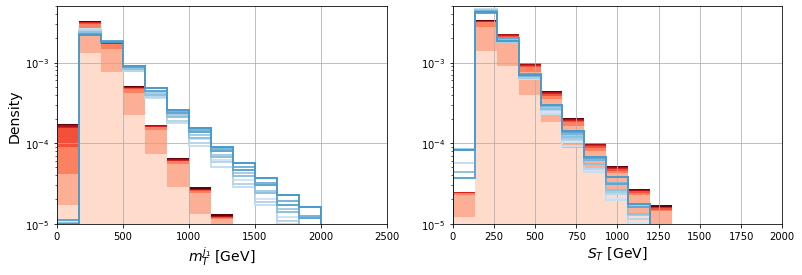

In [42]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# Mt jet info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 15
bin_range = [0,2500]

bkg_list = [mT_jet_wjets[:wjets_sample], mT_jet_wgamma[:wgamma_sample], mT_jet_ttjets[:ttjets_sample],
            mT_jet_zjets[:zjets_sample], 
            np.concatenate((mT_jet_tj[:tj_sample], mT_jet_tb[:tb_sample], mT_jet_tw[:tw_sample])),
            mT_jet_ttgamma[:ttgamma_sample],
            np.concatenate((mT_jet_zz[:zz_sample], mT_jet_wz[:wz_sample], mT_jet_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_jet_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)
ax[ncol].set_ylabel("Density",fontsize=14)


# ST info
ncol = 1
nbins = 15
bin_range = [0,2000]

bkg_list = [ST_wjets[:wjets_sample], ST_wgamma[:wgamma_sample], ST_ttjets[:ttjets_sample],
            ST_zjets[:zjets_sample], 
            np.concatenate((ST_tj[:tj_sample], ST_tb[:tb_sample], ST_tw[:tw_sample])),
            ST_ttgamma[:ttgamma_sample],
            np.concatenate((ST_zz[:zz_sample], ST_wz[:wz_sample], ST_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(ST_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2000)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/mt_jet_ST.pdf', bbox_inches='tight')

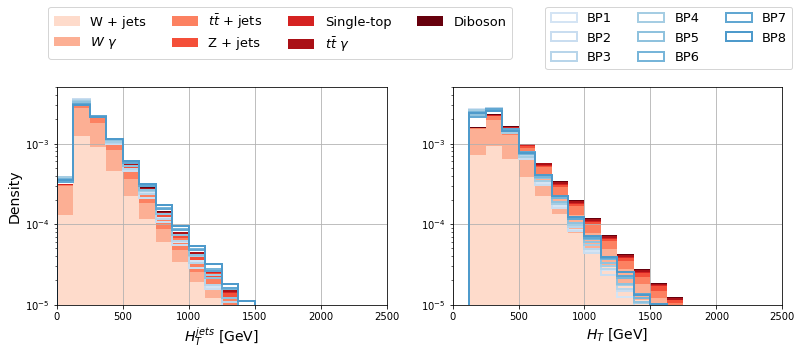

In [43]:
nbins = 20#np.asarray([121.16, 467.7, 814.2, 1160.8, 1507.3, 1853.9, 2200.4, 2546.9, 2893.5, 3240.0, 10000])

fig,ax = plt.subplots(1,2, figsize = (13,4))

# Ht info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
xlabels = [r"$H_{T}^{jets}$ [GeV]", r"$H_{T}^{jets}$ [GeV]"]
bin_range = [0,2500]
nbins = 20

bkg_list = [hadinfo_wjets[:wjets_sample,1], hadinfo_wgamma[:wgamma_sample,1], hadinfo_ttjets[:ttjets_sample,1],
            hadinfo_zjets[:zjets_sample,1], 
            np.concatenate((hadinfo_tj[:tj_sample,1], hadinfo_tb[:tb_sample,1], hadinfo_tw[:tw_sample,1])),
            hadinfo_ttgamma[:ttgamma_sample,1],
            np.concatenate((hadinfo_zz[:zz_sample,1],hadinfo_wz[:wz_sample,1],hadinfo_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.40, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}^{jets}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

# HT
ncol = 1

bkg_list = [hadinfo_wjets[:wjets_sample,0], hadinfo_wgamma[:wgamma_sample,0], hadinfo_ttjets[:ttjets_sample,0],
            hadinfo_zjets[:zjets_sample,0], 
            np.concatenate((hadinfo_tj[:tj_sample,0], hadinfo_tb[:tb_sample,0], hadinfo_tw[:tw_sample,0])),
            hadinfo_ttgamma[:ttgamma_sample,0],
            np.concatenate((hadinfo_zz[:zz_sample,0],hadinfo_wz[:wz_sample,0],hadinfo_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.05, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/HT_info_dist.pdf', bbox_inches='tight')

## ML Analysis

In [162]:
Z_BL_loops          = list(np.load('../data/models/Z_BL_MET100_BPI.npy'))
Z_BL_std_loops      = list(np.load('../data/models/Z_BL_std_MET100_BPI.npy'))
muhat_BL_loops      = list(np.load('../data/models/muhat_BL_MET100_BPI.npy'))
Z_MLL_loops         = list(np.load('../data/models/Z_MLL_MET100_BPI.npy'))
Z_MLL_std_loops     = list(np.load('../data/models/Z_MLL_std_MET100_BPI.npy'))
muhat_MLL_loops     = list(np.load('../data/models/muhat_MLL_MET100_BPI.npy'))
Z_MLL_new_loops     = list(np.load('../data/models/Z_MLL_new_MET100_BPI.npy'))
Z_MLL_new_std_loops = list(np.load('../data/models/Z_MLL_new_std_MET100_BPI.npy'))
muhat_MLL_new_loops = list(np.load('../data/models/muhat_MLL_new_MET100_BPI.npy'))
Z_sbc_loops         = list(np.load('../data/models/Z_sbc_MET100_BPI.npy'))
Z_sbc_std_loops     = list(np.load('../data/models/Z_sbc_std_MET100_BPI.npy'))

In [164]:
Z_sbc_loops

[array([3.02618869, 2.17545109, 1.57720981, 2.14950834, 1.37411889,
        1.83382841, 1.16247428, 1.35834233]),
 array([3.05495834, 1.84176614, 0.81987229, 1.52125155, 0.71403545,
        1.20857441, 0.42461823, 0.73938688]),
 array([2.66484006, 2.06486032, 1.47096246, 1.91458036, 1.28689423,
        1.64859085, 1.04499677, 1.19805622]),
 array([2.97866928, 2.07827628, 0.93396734, 1.46384709, 0.73217713,
        1.06866928, 0.42340172, 0.63829886]),
 array([2.35599994, 1.99051569, 1.48979671, 1.68989192, 1.22567187,
        1.29923161, 0.97750497, 1.02759357]),
 array([2.90530278, 2.2330206 , 1.43293421, 2.00147721, 1.2023996 ,
        1.59122725, 0.84502477, 1.05249932]),
 array([2.90334928, 1.92763594, 0.85000427, 1.43798311, 0.69993303,
        1.08827404, 0.40344088, 0.65139732]),
 array([2.87268383, 1.91351494, 0.8769783 , 1.42660705, 0.6895702 ,
        1.04992941, 0.40218799, 0.63345101]),
 array([2.87268383, 1.91351494, 0.8769783 , 1.42660705, 0.6895702 ,
        1.04992941, 

In [165]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [166]:
nobs = len(photon_SM)
#BPS_trained = np.asarray([0]) #np.arange(15)
BPS_trained = np.arange(8)
nobs_bp = round(nobs / len(BPS_trained))

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df = pd.DataFrame()

#np.random.seed(28890)

mask_list = []
for bp in BPS_trained:
    print(bp)
    BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = nobs_bp, replace = False)
    mask = np.ones(len(photon_NP[bp]), dtype=bool)
    mask[BP_indices] = False
    mask_list.append( mask )
    
    if bp == 0:
        
        df[lst[0]] = np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][BP_indices,0]])
        df[lst[1]] = np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][BP_indices,1]])
        df[lst[2]] = np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][BP_indices,2]])
        df[lst[3]] = np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][BP_indices,3]])

        df[lst[4]] = np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][BP_indices,0]])
        df[lst[5]] = np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][BP_indices,1]])
        df[lst[6]] = np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][BP_indices,2]])

        df[lst[7]] = np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][BP_indices,0]])
        df[lst[8]] = np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][BP_indices,1]])
        df[lst[9]] = np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][BP_indices,2]])
        df[lst[10]] = np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][BP_indices,3]])
        df[lst[11]] = np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][BP_indices,4]])

        df[lst[12]] = np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][BP_indices,0]])
        df[lst[13]] = np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][BP_indices,2]])

        df[lst[14]] = np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][BP_indices,0]])
        df[lst[15]] = np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][BP_indices,1]])
        df[lst[16]] = np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][BP_indices,2]])

        df[lst[17]] = np.concatenate([ST_SM[SM_indices], ST_NP[bp][BP_indices]])
        df[lst[18]] = np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][BP_indices]])

        df[lst[19]] = np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][BP_indices]])
        df[lst[20]] = np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][BP_indices]])
        df[lst[21]] = np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][BP_indices]])


        df['bkg_flag'] = np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][BP_indices]))) )

        df[lst[22]] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices]))])
        
        df['bp_flag'] = np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) ])
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][BP_indices,0] 
        df_aux[lst[1]] = photon_NP[bp][BP_indices,1] 
        df_aux[lst[2]] = photon_NP[bp][BP_indices,2] 
        df_aux[lst[3]] = photon_NP[bp][BP_indices,3] 

        df_aux[lst[4]] = jet_NP[bp][BP_indices,0] 
        df_aux[lst[5]] = jet_NP[bp][BP_indices,1] 
        df_aux[lst[6]] = jet_NP[bp][BP_indices,2] 

        df_aux[lst[7]] = lepton_NP[bp][BP_indices,0] 
        df_aux[lst[8]] = lepton_NP[bp][BP_indices,1] 
        df_aux[lst[9]] = lepton_NP[bp][BP_indices,2] 
        df_aux[lst[10]] = lepton_NP[bp][BP_indices,3] 
        df_aux[lst[11]] = lepton_NP[bp][BP_indices,4] 

        df_aux[lst[12]] = MET_NP[bp][BP_indices,0] 
        df_aux[lst[13]] = MET_NP[bp][BP_indices,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][BP_indices,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][BP_indices,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][BP_indices,2] 

        df_aux[lst[17]] = ST_NP[bp][BP_indices] 
        df_aux[lst[18]] = MET_sig_NP[bp][BP_indices] 

        df_aux[lst[19]] = mT_photon_NP[bp][BP_indices] 
        df_aux[lst[20]] = mT_jet_NP[bp][BP_indices] 
        df_aux[lst[21]] = mT_lepton_NP[bp][BP_indices] 


        df_aux['bkg_flag'] = np.zeros(len(photon_NP[bp][BP_indices]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][BP_indices]))
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][BP_indices])) * (bp+1) 
        
        df = pd.concat((df, df_aux))
df_array = np.asarray(df)
df

0
1
2
3
4
5
6
7


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1,bp_flag
0,38.22,-2.226,1.917,1.0,151.15,-1.187,1.529,19.80,-1.971,-2.526,...,179.80,2.0,209.17,13.999365,181.656449,355.429117,77.774985,2.0,0.0,0.0
1,64.86,0.910,1.261,1.0,613.55,-0.347,-0.375,25.66,0.245,1.116,...,1312.16,6.0,704.07,3.108215,119.535495,534.494273,80.735814,3.0,0.0,0.0
2,10.82,-0.168,2.653,1.0,120.21,1.448,1.007,17.87,-0.826,-0.253,...,245.58,4.0,148.90,7.328620,59.313866,236.229807,62.113913,1.0,0.0,0.0
3,35.98,-1.535,1.362,1.0,163.97,-0.876,0.100,48.34,-0.016,-2.290,...,273.73,2.0,248.29,10.164247,156.838067,340.258050,16.372035,2.0,0.0,0.0
4,190.63,0.023,-2.807,2.0,154.25,1.210,-0.443,51.22,2.284,0.756,...,182.12,2.0,396.10,7.087761,288.303423,245.675868,58.483536,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14.13,1.973,1.267,1.0,232.98,1.568,-1.397,20.63,0.435,-1.097,...,500.48,5.0,267.74,9.020432,3.908954,424.455405,119.565888,0.0,1.0,8.0
24996,12.22,0.832,-2.299,1.0,356.29,0.518,0.458,10.38,-0.183,-2.963,...,438.33,3.0,378.89,18.504113,24.262053,752.332341,20.081012,0.0,1.0,8.0
24997,25.06,-1.368,-0.060,1.0,115.25,-0.792,-0.545,29.19,-1.052,-2.754,...,115.25,1.0,169.50,10.144236,108.538128,245.616054,66.182345,0.0,1.0,8.0
24998,11.40,1.444,3.012,1.0,143.09,2.392,-0.600,13.27,-0.713,1.830,...,299.95,3.0,167.76,13.227905,53.240059,352.755041,6.182990,0.0,1.0,8.0


In [167]:
print('There are ' + str(len(np.where(df_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(8):
    print('There are ' + str(len(np.where(df_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 200001 bkg events
There are 25000 BP1 events
There are 25000 BP2 events
There are 25000 BP3 events
There are 25000 BP4 events
There are 25000 BP5 events
There are 25000 BP6 events
There are 25000 BP7 events
There are 25000 BP8 events


In [168]:
SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

#BPS_analyzed = np.asarray([0])
BPS_analyzed = np.arange(8)

df_test = pd.DataFrame()

for bp in BPS_analyzed:
    if bp in BPS_trained:
        mask = mask_list[np.where(BPS_trained == bp)[0][0]]
        mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 75000
    else:
        BP_indices = np.random.choice(np.arange(len(photon_NP[bp])), size = 15_000, replace = False)
        mask = np.zeros(len(photon_NP[bp]), dtype=bool)
        mask[BP_indices] = True
    print(bp)
    #mask = mask_list[bp]
    #mask[np.random.choice(np.arange(len(mask)), (len(mask) - 100_000), replace = False)] = False # Set to false everything but 15000
    if bp == 0:
        
        df_test[lst[0]] = np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][mask,0]])
        df_test[lst[1]] = np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][mask,1]])
        df_test[lst[2]] = np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][mask,2]])
        df_test[lst[3]] = np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][mask,3]])

        df_test[lst[4]] = np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][mask,0]])
        df_test[lst[5]] = np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][mask,1]])
        df_test[lst[6]] = np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][mask,2]])

        df_test[lst[7]] = np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][mask,0]])
        df_test[lst[8]] = np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][mask,1]])
        df_test[lst[9]] = np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][mask,2]])
        df_test[lst[10]] = np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][mask,3]])
        df_test[lst[11]] = np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][mask,4]])

        df_test[lst[12]] = np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][mask,0]])
        df_test[lst[13]] = np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][mask,2]])

        df_test[lst[14]] = np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][mask,0]])
        df_test[lst[15]] = np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][mask,1]])
        df_test[lst[16]] = np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][mask,2]])

        df_test[lst[17]] = np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][mask]])
        df_test[lst[18]] = np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][mask]])

        df_test[lst[19]] = np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][mask]])
        df_test[lst[20]] = np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][mask]])
        df_test[lst[21]] = np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][mask]])


        df_test['bkg_flag_pool'] = np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][mask]))) )

        df_test[lst[22]] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask]))])
        
        df_test['bp_flag'] = np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][mask])) * (bp+1) ])
        
    else:
        df_aux = pd.DataFrame()
        
        df_aux[lst[0]] = photon_NP[bp][mask,0] 
        df_aux[lst[1]] = photon_NP[bp][mask,1] 
        df_aux[lst[2]] = photon_NP[bp][mask,2] 
        df_aux[lst[3]] = photon_NP[bp][mask,3] 

        df_aux[lst[4]] = jet_NP[bp][mask,0] 
        df_aux[lst[5]] = jet_NP[bp][mask,1] 
        df_aux[lst[6]] = jet_NP[bp][mask,2] 

        df_aux[lst[7]] = lepton_NP[bp][mask,0] 
        df_aux[lst[8]] = lepton_NP[bp][mask,1] 
        df_aux[lst[9]] = lepton_NP[bp][mask,2] 
        df_aux[lst[10]] = lepton_NP[bp][mask,3] 
        df_aux[lst[11]] = lepton_NP[bp][mask,4] 

        df_aux[lst[12]] = MET_NP[bp][mask,0] 
        df_aux[lst[13]] = MET_NP[bp][mask,2] 

        df_aux[lst[14]] = hadinfo_NP[bp][mask,0] 
        df_aux[lst[15]] = hadinfo_NP[bp][mask,1] 
        df_aux[lst[16]] = hadinfo_NP[bp][mask,2] 

        df_aux[lst[17]] = ST_NP[bp][mask] 
        df_aux[lst[18]] = MET_sig_NP[bp][mask] 

        df_aux[lst[19]] = mT_photon_NP[bp][mask] 
        df_aux[lst[20]] = mT_jet_NP[bp][mask] 
        df_aux[lst[21]] = mT_lepton_NP[bp][mask] 


        df_aux['bkg_flag_pool'] = np.zeros(len(photon_NP[bp][mask]))

        df_aux[lst[22]] = np.ones(len(photon_NP[bp][mask]))
        
        df_aux['bp_flag'] = np.ones(len(photon_NP[bp][mask])) * (bp+1)
        
        df_test = pd.concat((df_test, df_aux))
df_test_array = np.asarray(df_test)
df_test

0
1
2
3
4
5
6
7


,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1,bp_flag
0,28.93,-0.767,2.152,1.0,295.53,-2.050,-0.633,54.50,-0.985,-3.072,...,368.81,3.0,378.96,10.166024,27.149082,505.523428,75.885283,1.0,0.0,0.0
1,22.80,-0.228,-0.242,1.0,200.67,-0.846,-1.842,31.93,0.527,-0.761,...,415.62,3.0,255.40,8.669293,113.035267,378.093947,149.899382,5.0,0.0,0.0
2,57.56,-0.495,-0.881,1.0,325.23,-0.127,2.513,18.77,-1.171,0.922,...,745.36,6.0,401.56,3.786132,39.185146,349.404232,82.467567,2.0,0.0,0.0
3,27.41,1.041,2.159,1.0,153.08,1.349,1.453,23.61,1.167,-2.628,...,253.90,2.0,204.10,12.235168,135.776332,358.794073,47.772085,1.0,0.0,0.0
4,10.33,1.695,1.299,1.0,258.43,1.212,2.679,69.83,0.848,-1.338,...,408.79,4.0,338.59,7.793430,66.387829,421.938710,88.057094,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92691,41.13,1.082,-0.862,2.0,1716.19,0.534,2.901,18.38,1.263,0.317,...,1950.17,4.0,1775.70,33.878359,164.826867,3237.516941,84.376151,0.0,1.0,8.0
92692,23.25,1.019,-1.799,1.0,398.87,0.697,0.085,12.19,0.773,1.947,...,431.39,2.0,434.31,19.465202,117.948709,819.109983,84.319937,0.0,1.0,8.0
92693,15.99,-1.381,-0.726,1.0,121.80,-1.139,2.262,16.17,0.308,-3.123,...,121.80,1.0,153.96,10.546369,13.038048,251.944372,80.053617,0.0,1.0,8.0
92694,12.14,-1.202,-0.001,1.0,166.97,1.762,-2.543,12.92,-0.540,-0.242,...,272.10,2.0,192.03,9.950500,5.199350,328.541805,16.624430,0.0,1.0,8.0


In [169]:
print('There are ' + str(len(np.where(df_test_array[:,24] == 0)[0])) + ' bkg events')
for i in np.arange(8):
    print('There are ' + str(len(np.where(df_test_array[:,24] == (i+1))[0])) + ' BP' + str(i+1) + ' events')

There are 439041 bkg events
There are 90376 BP1 events
There are 91100 BP2 events
There are 91159 BP3 events
There are 91056 BP4 events
There are 93346 BP5 events
There are 93284 BP6 events
There are 92135 BP7 events
There are 92696 BP8 events


In [170]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
val_size   = nobs - train_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
val_indices   = random_indices[train_size:]

In [171]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [172]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [173]:
print('y:', df.columns[-2]) # Just to check

y: SM=0 - NP=1


In [174]:
x_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_train        = df_array[train_indices, -2]

x_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_test        = df_test_array[:, -2]

x_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_val        = df_array[val_indices, -2]

In [175]:
for i, ibkg in enumerate(bkg):
    ind_train = np.where(bkg_flag_train == (i + 1))[0]
    if(len(ind_train) < globals()[ibkg + '_expected']): 
        print('In training there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_train), globals()[ibkg + '_expected']))
        
    ind_test = np.where(bkg_flag_test == (i + 1))[0]
    if(len(ind_test) < globals()[ibkg + '_expected']): 
        print('In testing there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_test), globals()[ibkg + '_expected']))
        
    ind_val = np.where(bkg_flag_val == (i + 1))[0]
    if(len(ind_val) < globals()[ibkg + '_expected']): 
        print('In val there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_val), globals()[ibkg + '_expected']))

In [176]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)
x_val   = x_scaler.transform(x_val)

In [177]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
fit = True
if fit:
    classifier.fit(x_train, y_train, 
                   eval_set = [(x_train, y_train), (x_val, y_val)],
                   verbose  =True)
    classifier.save_model(f'../data/models/BPI_MET100_{len(Z_BL_loops)}.json')
else:
    classifier.load_model(f'../data/models/BPI_MET100_{len(Z_BL_loops)}.json')


[0]	validation_0-logloss:0.64827	validation_1-logloss:0.64881
[1]	validation_0-logloss:0.61148	validation_1-logloss:0.61248
[2]	validation_0-logloss:0.58010	validation_1-logloss:0.58147
[3]	validation_0-logloss:0.55332	validation_1-logloss:0.55512
[4]	validation_0-logloss:0.53089	validation_1-logloss:0.53308
[5]	validation_0-logloss:0.51161	validation_1-logloss:0.51403
[6]	validation_0-logloss:0.49452	validation_1-logloss:0.49712
[7]	validation_0-logloss:0.47957	validation_1-logloss:0.48246
[8]	validation_0-logloss:0.46627	validation_1-logloss:0.46942
[9]	validation_0-logloss:0.45456	validation_1-logloss:0.45789
[10]	validation_0-logloss:0.44475	validation_1-logloss:0.44827
[11]	validation_0-logloss:0.43584	validation_1-logloss:0.43962
[12]	validation_0-logloss:0.42777	validation_1-logloss:0.43168
[13]	validation_0-logloss:0.42021	validation_1-logloss:0.42432
[14]	validation_0-logloss:0.41313	validation_1-logloss:0.41741
[15]	validation_0-logloss:0.40741	validation_1-logloss:0.41190
[1

In [178]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(x_test).T[1]

In [179]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total = np.zeros(nvals) 
fpr_total = np.zeros(nvals) 
tpr_bkg   = np.zeros((len(bkg), nvals))
fpr_bkg   = np.zeros((len(bkg), nvals))

for ith, th in tqdm(enumerate(np.linspace(0,1, nvals))):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))

    for i, ibkg in enumerate(bkg):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]
    
        tpr_bkg[i, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bkg[i, ith] = len(fp) / (len(fp) + len(tn))

50it [00:02, 17.29it/s]


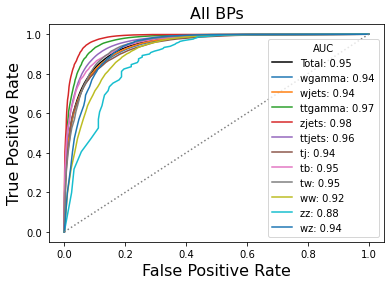

In [180]:
plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total: {:.2f}'.format(auc(fpr_total, tpr_total)))

for i, ibkg in enumerate(bkg):
    plt.plot(fpr_bkg[i,:], tpr_bkg[i,:], label = ibkg + ': {:.2f}'.format(auc(fpr_bkg[i,:], tpr_bkg[i,:])))
plt.legend(title = 'AUC')

plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"All BPs",fontsize=16)
plt.savefig(f'../graph/ROC_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

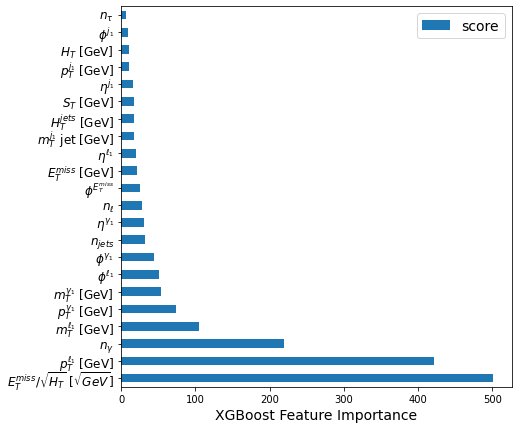

In [181]:
lst1 = ['$p_T^{\gamma_1}$ [GeV]', '$\eta^{\gamma_1}$', '$\phi^{\gamma_1}$', '$n_\gamma$',
       '$p_T^{j_1}$ [GeV]', '$\eta^{j_1}$', '$\phi^{j_1}$',
       '$p_T^{\ell_1}$ [GeV]', '$\eta^{\ell_1}$', '$\phi^{\ell_1}$', '$n_\ell$', '$n_{\\tau}$',
       '$E_T^{miss}$ [GeV]', '$\phi^{E_T^{miss}}$',
       '$H_T$ [GeV]', '$H_T^{jets}$ [GeV]', '$n_{jets}$',
       '$S_T$ [GeV]', 
       '$E_T^{miss}/\sqrt{H_T}$ [$\sqrt{GeV}$]',
       '$m_T^{\gamma_1}$ [GeV]', '$m_T^{j_{1}}$ jet [GeV]', '$m_T^{\ell_1}$ [GeV]',
       'SM=0 - NP=1']

fig, ax = plt.subplots(figsize = (7,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("XGBoost Feature Importance", fontsize = 14)
ax.set_yticklabels(np.asarray(lst1)[np.argsort(values)[::-1]], fontsize = 12)

ax.legend(fontsize = 14)

plt.savefig(f'../graph/ImpVars_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

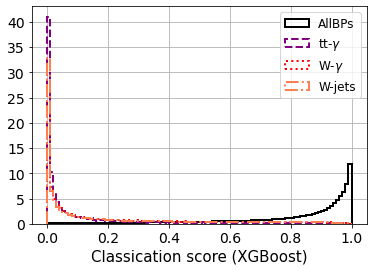

In [182]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'AllBPs', lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig(f'../graph/MLOutput_dist_MET100_BPI_{len(Z_BL_loops)}.pdf', bbox_inches="tight")

In [183]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [184]:
len(np.where(bkg_flag_test != 0)[0])

439041

In [185]:
len(np.where(bkg_flag_test == 0)[0])

735152

## Sequential selection criteria

In [186]:
nbins = 10
indices_aux = np.arange(len(df_test_array))

n_np0 = []
for bp in np.arange(8):
    n_np0.append( len(np.where(df_test_array[:, 24] == (bp+1))[0]) )
    
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 3), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    ZN_sup = np.zeros(nbins)
    ZN_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_sup, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and ( np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_sup[icut] = np.mean(Z_norm)
            Z.append( ZN_sup[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])
        
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)
        
        S_expected_aux = np.zeros(8)
        for bp in np.arange(8):
            n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
            S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5):
            Z_norm = np.zeros(8)
            for bp in np.arange(8):
                Z_norm[bp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp]))
                Z_norm[bp] = Z_norm[bp] / S_expected[bp]
            ZN_inf[icut] = np.mean(Z_norm)
            Z.append( ZN_inf[icut] )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut     = np.argmax(np.asarray(Z))
    indices_aux = indices[max_cut]
    max_cut     = np.argmax((ZN_inf, ZN_sup))
    if max_cut >= len(ZN_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(ZN_sup)]) + '; <Z Norm> = ' + str(ZN_sup[max_cut - len(ZN_inf)]))
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(ZN_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(ZN_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; <Z Norm> = ' + str(ZN_inf[max_cut]))
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = np.zeros(8)
for bp in np.arange(8):
    n_np = len(np.where( (df_test_array[indices_inf, 24] == (bp+1)) )[0])
    S_expected_aux[bp] = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0[bp]))
    
# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (np.min(S_expected_aux) > 5): 
    for bp in np.arange(8):
        print('\n')
        print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux[bp]) * np.log(1 + S_expected_aux[bp] / B_expected_aux) - S_expected_aux[bp])))
        print('Expected Background = ' + str(B_expected_aux))
        print('Expected Signal = ' + str(S_expected_aux[bp]))

MET sig [GeV] >= 12.841278563780092; <Z Norm> = 0.0038650044381625523
num_taus <= 1.1111111111111112; <Z Norm> = 0.0038650044381625523
MET $\phi$ <= 3.142; <Z Norm> = 0.0038650044381625523
photon $\eta$ >= -1.8425555555555557; <Z Norm> = 0.0038785823253272432
num_jets <= 7.666666666666667; <Z Norm> = 0.0038825157812826666
jet $\eta$ <= 3.4717777777777776; <Z Norm> = 0.0038827972005563674
lepton $\phi$ <= 3.142; <Z Norm> = 0.0038827972005563674
num photon <= 2.0; <Z Norm> = 0.0038827972005563674
$S_T$ [GeV] <= 1468.09; <Z Norm> = 0.0038909185425014445
num lepton <= 2.2222222222222223; <Z Norm> = 0.0038917707483813553
lepton $p_T$ [GeV] <= 94.03333333333333; <Z Norm> = 0.004223654072117798
jet $p_T$ [GeV] <= 1271.832222222222; <Z Norm> = 0.004224389998743378
$H_T$ (jets) [GeV] <= 1808.2766666666666; <Z Norm> = 0.004224389998743378
lepton $\eta$ <= 2.498; <Z Norm> = 0.004224389998743378
$m_T$ lepton [GeV] <= 375.92592391967935; <Z Norm> = 0.004225863006838271
$H_T$ [GeV] <= 2153.586666666

In [187]:
write = True
if write:
    with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 106.38it/s]


Final results: for BP 1
 
Z = 2.228334926623205; Z_std = 0.204918849298954
B_exp = 2904.717; B_exp_std = 43.56825577183461
S_exp = 121.041; S_exp_std = 11.061343453667822


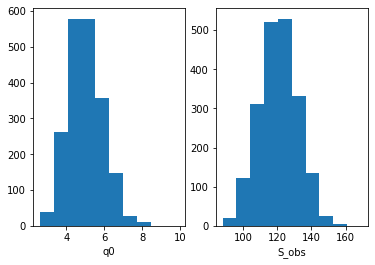

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 109.69it/s]

Final results: for BP 2
 
Z = 1.1160147996798084; Z_std = 0.14484415014864416
B_exp = 2905.2375; B_exp_std = 44.023074560393894
S_exp = 60.843; S_exp_std = 7.677652701184132


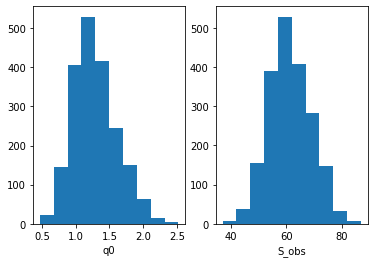

100%|███████████████████████████████| 2000/2000 [00:31<00:00, 64.16it/s]


Final results: for BP 3
 
Z = 0.40492765662102964; Z_std = 0.08880127544406036
B_exp = 2903.1725; B_exp_std = 44.260058108298956
S_exp = 21.785; S_exp_std = 4.657765021982109


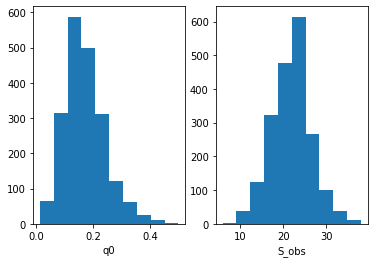

100%|███████████████████████████████| 2000/2000 [00:34<00:00, 58.42it/s]


Final results: for BP 4
 
Z = 1.1437563076031312; Z_std = 0.14668958296574935
B_exp = 2901.6045; B_exp_std = 43.07172018563921
S_exp = 62.137; S_exp_std = 7.836085183304226


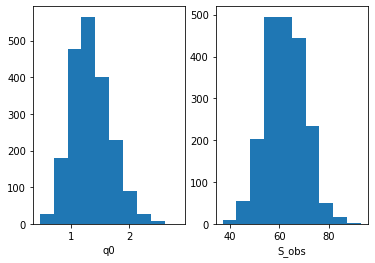

100%|███████████████████████████████| 2000/2000 [00:43<00:00, 46.16it/s]


Final results: for BP 5
 
Z = 0.3709331155822313; Z_std = 0.08789010994808036
B_exp = 2904.4585; B_exp_std = 43.153415597725285
S_exp = 20.1995; S_exp_std = 4.5180415834739724


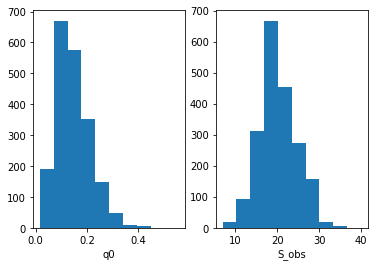

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 109.95it/s]


Final results: for BP 6
 
Z = 0.8282417810300885; Z_std = 0.12510647984135184
B_exp = 2901.4165; B_exp_std = 44.17688340919943
S_exp = 44.732; S_exp_std = 6.699490726913502


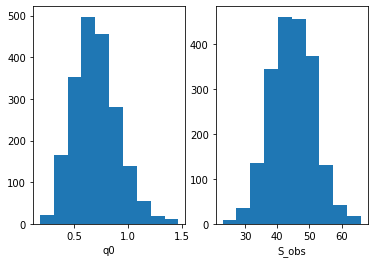

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 110.66it/s]


Final results: for BP 7
 
Z = 0.20329750155216808; Z_std = 0.06492603334729229
B_exp = 2903.3095; B_exp_std = 44.525966690797404
S_exp = 10.9325; S_exp_std = 3.2974147070091138


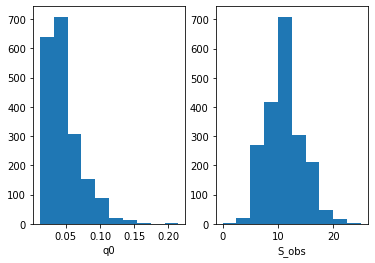

100%|██████████████████████████████| 2000/2000 [00:18<00:00, 110.13it/s]


Final results: for BP 8
 
Z = 0.4988477788354525; Z_std = 0.0968299600285335
B_exp = 2903.5755; B_exp_std = 43.59543897875098
S_exp = 26.9135; S_exp_std = 5.108132511006346


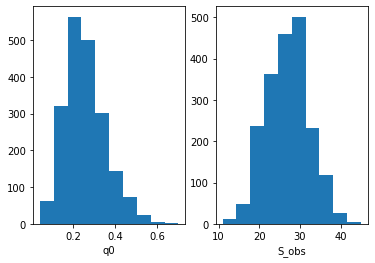

In [188]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]

Z_sbc_std_BPs = np.ones(8) * (-99)
Z_sbc_BPs = np.ones(8) * (-99)
for bp in np.arange(8):
    
    NP_test_pool = np.where(df_test_array[:,24] == (bp+1))[0]

    q0_exp = np.zeros(nexperiments)
    B_observed_exp = np.zeros(nexperiments)
    S_observed_exp = np.zeros(nexperiments)
    for nexp in tqdm(range(nexperiments)):
        # Let's create a pseudo-experiment
        SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
        NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
        indices_aux = np.concatenate((NP_indices, SM_indices))

        # Let's make the cuts

        variables = list(sup_cuts.keys())
        for i in range(len(variables)):
            ind_var = np.where(df_test.columns == variables[i])[0][0]
            indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                    (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                                   )[0]]
        # Let's calculate everything

        n_np = len(np.where(df_test_array[indices_aux, 24] == (bp+1))[0])

        n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

        S_observed_exp[nexp] = n_np

        # Formula discovery
        B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                               n_ttjets + n_zjets + n_wz + \
                               n_zz + n_ww + n_tj + \
                               n_tb + n_tw

        N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                     n_ttjets + n_zjets + n_wz + \
                     n_zz + n_ww + n_tj + \
                     n_tb + n_tw
        
        if (B_observed_exp[nexp] >= 5) and (n_np > 5): 
            q0_exp[nexp] = -2 * N_observed * np.log(B_observed_exp[nexp] / N_observed) -2 * (N_observed - B_observed_exp[nexp])
        else:
            q0_exp[nexp] = -99
            
    q0_exp = q0_exp[np.where(q0_exp > 0)[0]]
    Z_sbc_BPs[bp] = np.sqrt(np.median(q0_exp))
    Z_sbc_std_BPs[bp] = np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))
    print('Final results: for BP ' + str(bp+1) + '\n ')
    print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
    print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
    print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))
    fig,ax = plt.subplots(1,2)
    
    ax[0].hist(q0_exp)
    ax[0].set_xlabel('q0')
    ax[1].hist(S_observed_exp)
    ax[1].set_xlabel('S_obs')
    plt.show()

In [125]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
print(imp_vars)

['MET sig [GeV]' 'lepton $p_T$ [GeV]' 'num photon' '$m_T$ lepton [GeV]']


In [140]:
name_imp_vars = np.asarray(lst1)[np.argsort(values)[::-1]][:4]
print(name_imp_vars)

['$p_T^{\\ell_1}$ [GeV]' '$E_T^{miss}/\\sqrt{H_T}$ [$\\sqrt{GeV}$]'
 '$n_\\gamma$' '$m_T^{\\ell_1}$ [GeV]']


In [144]:
np.argsort(values)[::-1][:4]

array([ 7, 18,  3, 21])

In [148]:
np.min( [np.min(SM[imp_vars[0]]),np.min(NP[imp_vars[0]])])

10.01

In [138]:
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('white'), cmap_name = 'NP_cmap')

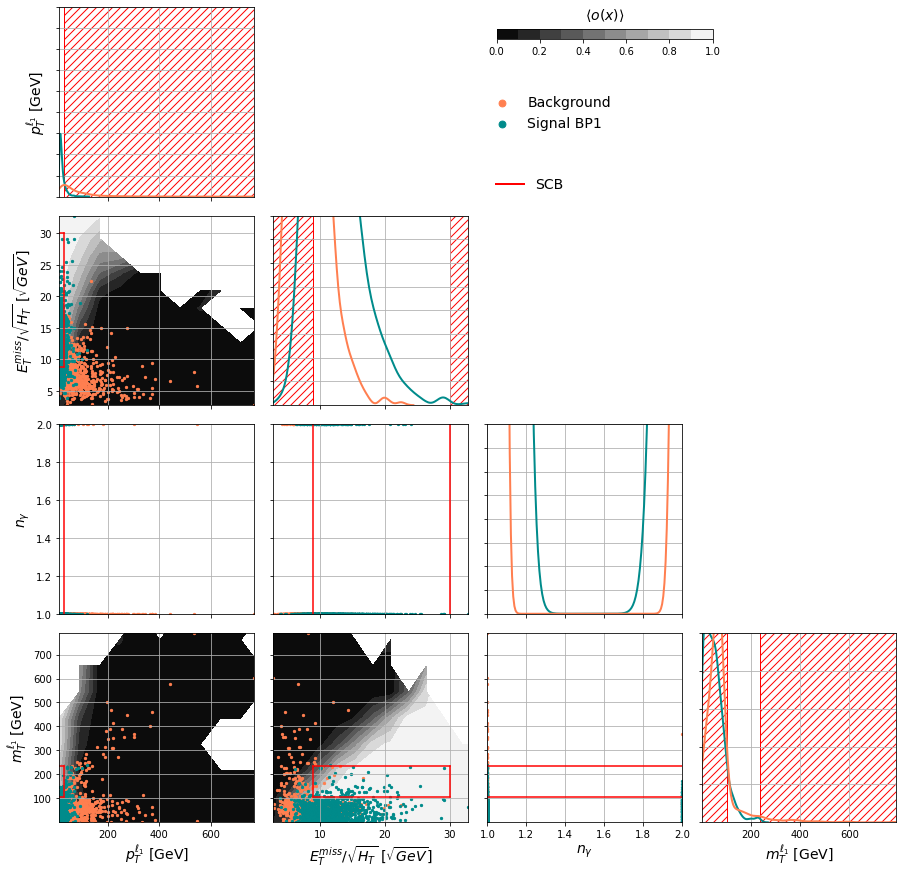

In [151]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bp_flag'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  1000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  1000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

#limites = [[4,35], [0,250], [0,5], [0,500]]
limites = [[np.min( [np.min(SM[imp_vars[0]]),np.min(NP[imp_vars[0]])]), np.max( [np.max(SM[imp_vars[0]]),np.max(NP[imp_vars[0]])])],
           [np.min( [np.min(SM[imp_vars[1]]),np.min(NP[imp_vars[1]])]), np.max( [np.max(SM[imp_vars[1]]),np.max(NP[imp_vars[1]])])],
           [np.min( [np.min(SM[imp_vars[2]]),np.min(NP[imp_vars[2]])]), np.max( [np.max(SM[imp_vars[2]]),np.max(NP[imp_vars[2]])])],
           [np.min( [np.min(SM[imp_vars[3]]),np.min(NP[imp_vars[3]])]), np.max( [np.max(SM[imp_vars[3]]),np.max(NP[imp_vars[3]])])]
            ]
ylimites = [[0,0.18], [0,0.04], [0,0.02], [0,0.01]]

rand_ind = np.random.choice(range(len(df_test)), size =  len(df_test), replace = False)
aux = df_test.iloc[rand_ind]
y_pred_aux = y_pred_xg[rand_ind]

with open(f'../data/cuts/MET100_BPI_supCuts_{len(Z_BL_loops)}.txt', "r") as fp:
    # Load the dictionary from the file
    sup_cuts = json.load(fp)
with open(f'../data/cuts/MET100_BPI_infCuts_{len(Z_BL_loops)}.txt', "r") as fp:
    # Load the dictionary from the file
    inf_cuts = json.load(fp)
        
fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = 'solid')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], facecolor = 'none', edgecolor = 'red', zorder = 0, hatch = '///')
                ax[i,j].set_ylim(ylimites[i])
            else:
                stats, xedge, yedge, _ = binned_statistic_2d(aux[imp_vars[j]], aux[imp_vars[i]], y_pred_aux, bins = 22)
                im_NP = ax[i,j].contourf(xedge[:-1], yedge[:-1], stats.T, cmap=NP_cmap, zorder = 0, levels = np.linspace(0,1,11))
                ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'coral', rasterized=True, label = 'Background')
                ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 20.8, marker = '.', 
                                        c = 'darkcyan', rasterized=True, label = 'Signal BP1')
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')

                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(name_imp_vars[0], fontsize = 14)
ax[3,1].set_xlabel(name_imp_vars[1], fontsize = 14)
ax[3,2].set_xlabel(name_imp_vars[2], fontsize = 14)
ax[3,3].set_xlabel(name_imp_vars[3], fontsize = 14)

ax[0,0].set_ylabel(name_imp_vars[0], fontsize = 14)
ax[1,0].set_ylabel(name_imp_vars[1], fontsize = 14)
ax[2,0].set_ylabel(name_imp_vars[2], fontsize = 14)
ax[3,0].set_ylabel(name_imp_vars[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])



# Legends------------------------------------------

ax[1,0].legend(loc = 'upper right', bbox_to_anchor=(2.9, 1.7), fontsize = 14, frameon = False, markerscale=3)

cax = fig.add_axes([0.53, 0.85, 0.2, 0.01])
cbar_NP = plt.colorbar(im_NP, cax=cax, orientation = 'horizontal')
cbar_NP.set_label(r'$\langle o(x) \rangle$', labelpad=-50, fontsize = 14)

patch1 = mlines.Line2D([], [], color='red', label='SCB', linestyle='-', markerfacecolor='none', markeredgewidth=2, lw = 2)
patch2 = mlines.Line2D([], [], color='red', label='BP 1', linestyle='-.', markerfacecolor='none', markeredgewidth=2, lw = 2)

# Add custom legend with boxes
ax[0,0].legend(handles=[patch1], loc = 'lower left', bbox_to_anchor=(2.18, -0.04), fontsize = 14, frameon = False )

plt.savefig(f'../graph/MET100_BPI_ImpVars_dist_{len(Z_BL_loops)}.pdf', bbox_inches='tight')

## Binned likelihood

In [189]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [190]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(735152,)


In [191]:
B_expected = int(B_expected)

B_expected:  147986

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


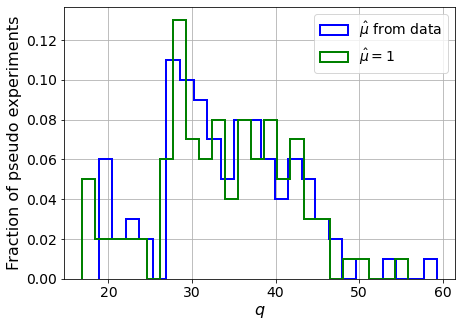

BP1

S_expected:  449.10190656505256
muhat mean:  1.025
Z_bins:  5.78108385788413
std Z_bins:  0.686476695073795
Z_bins mu=1:  5.783383930138872
std Z_bins mu=1:  0.6847497924134401

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


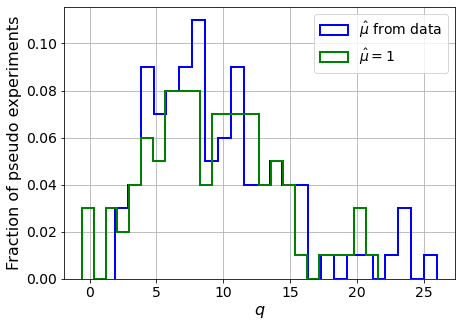

BP2

S_expected:  291.1381847935
muhat mean:  1.0470000000000002
Z_bins:  2.909222035755766
std Z_bins:  0.8877000727739496
Z_bins mu=1:  2.909222035755766
std Z_bins mu=1:  0.8207744745290996

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


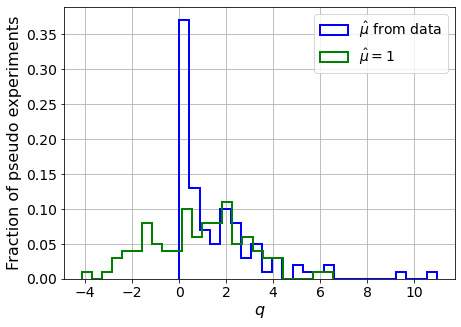

BP3

S_expected:  111.55838576058001
muhat mean:  0.8845000000000001
Z_bins:  0.9263384836775554
std Z_bins:  1.0868509275707379
Z_bins mu=1:  0.9756890111434314
std Z_bins mu=1:  1.0243024114114865

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


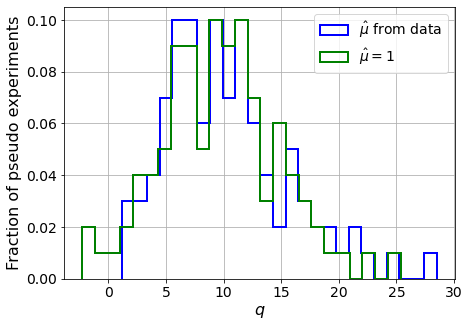

BP4

S_expected:  216.0519911529994
muhat mean:  1.065
Z_bins:  3.1132342630556473
std Z_bins:  0.8565601083461875
Z_bins mu=1:  3.1110162284047274
std Z_bins mu=1:  0.8241914454521581

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


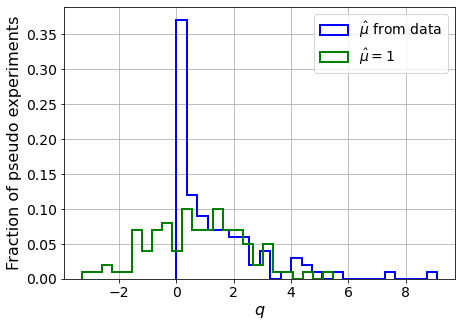

BP5

S_expected:  83.3632825857558
muhat mean:  0.8995000000000002
Z_bins:  0.8589302536307625
std Z_bins:  0.9727262574253445
Z_bins mu=1:  0.8886172970867963
std Z_bins mu=1:  0.9210646969054204

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


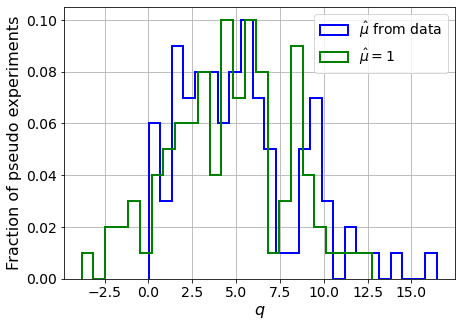

BP6

S_expected:  136.98878196000487
muhat mean:  1.037
Z_bins:  2.1759670081094056
std Z_bins:  0.7843997450200135
Z_bins mu=1:  2.175447643724486
std Z_bins mu=1:  0.7661537426104154

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


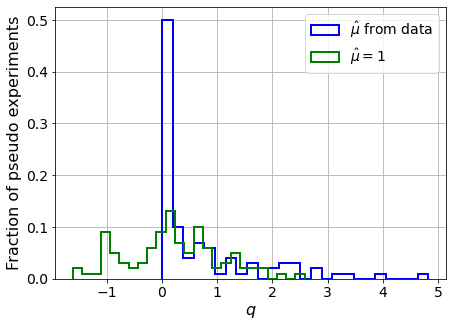

BP7

S_expected:  40.81006134556522
muhat mean:  0.9645000000000001
Z_bins:  0.4345621883337375
std Z_bins:  1.1322908709121118
Z_bins mu=1:  0.42885002019371954
std Z_bins mu=1:  0.988455257583796

--------

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.01


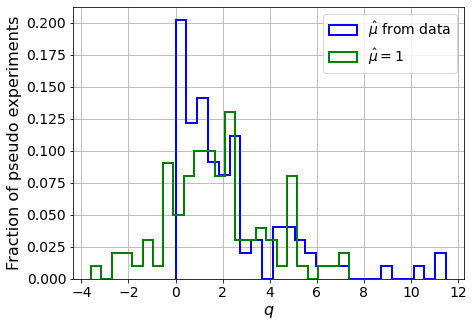

BP8

S_expected:  77.67573159154287
muhat mean:  0.9893939393939396
Z_bins:  1.213686585195848
std Z_bins:  0.9928457461159228
Z_bins mu=1:  1.2200079429234707
std Z_bins mu=1:  0.8710602494045598

--------



In [192]:
D_or_E = 'discovery'
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]]
# requested number of pseudo experiments
num_pseudo = 100
    
print('B_expected: ', B_expected)
print('')
Z_BL_BPs = np.ones(8) * (-99)
Z_BL_std_BPs = np.ones(8) * (-99)
muhat_BL = np.ones(8) * (-99)
for bp in BPS_analyzed:
    Z_BL = BL_test_fast(D_or_E, pred_XG_SM, y_pred_xg[np.where( (df_test_array[:,24] == (bp+1)) )[0]], B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 
    
    Z_BL_BPs[bp] = Z_BL[0]
    Z_BL_std_BPs[bp] = Z_BL[1]
    muhat_BL[bp] = Z_BL[2]
    
    print('BP' + str(bp+1) + '\n')
    print('S_expected: ', S_expected[bp])
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=1: ', Z_BL[3])
    print('std Z_bins mu=1: ', Z_BL[4])
    print('')
    print('--------\n')

## KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [           -inf            -inf            -inf            -inf
            -inf            -inf  1.20575853e+04  1.16794916e+04
  1.11885834e+04  1.05978177e+04  9.90503249e+03  9.08257157e+03
  8.10885178e+03  6.95718279e+03  5.59401268e+03  3.99978202e+03
  2.13864145e+03 -9.38530191e+00 -2.41069772e+03 -5.20367715e+03]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9064.3503

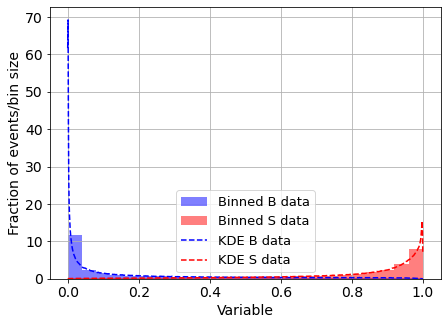

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0019008479046983867


In [193]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] > 0)[0]]

kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        50000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

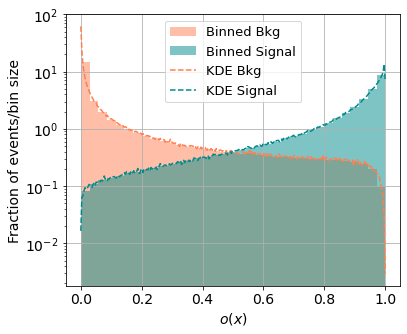

In [194]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,300)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='coral',alpha=0.5, linewidth=2, label=r'Binned Bkg');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='darkcyan',alpha=0.5, linewidth=2, label=r'Binned Signal');

plt.plot(s_vals, dens_bkg, color='coral',label=r'KDE Bkg',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='darkcyan',label=r'KDE Signal',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlabel("$o(x)$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_ALLBPs.pdf', bbox_inches='tight')

In [195]:

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


0:10000
3 done
4 done
0.003535019152362048
0.003535019152362048
B_expected:  147986
S_expected:  449

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


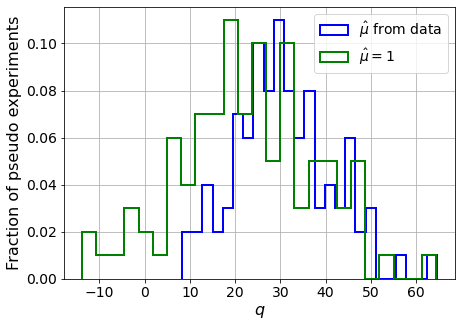

BP1
muhat mean:  0.6460000000000001
Z_MLL:  5.480095749924657
std Z_MLL:  0.9674299441774826
Z_MLL mu=1:  4.781604701883628
std Z_MLL mu=1:  1.5753473562976874
Z_MLL new:  3.8360128201559616
std Z_MLL new:  1.0100204349725517

--------

1:10000
3 done
4 done
0.0032458471050217136
0.0032458471050217136
B_expected:  147986
S_expected:  291

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


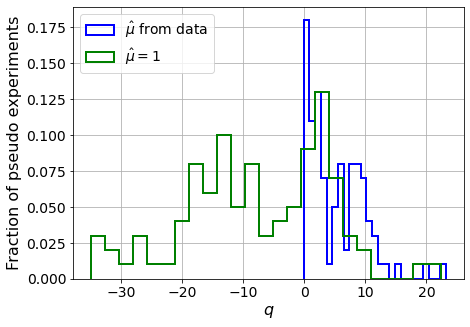

BP2
muhat mean:  0.34550000000000003
Z_MLL:  2.0544482638783856
std Z_MLL:  1.101786590739798
Z_MLL mu=1:  2.8130193462186566
std Z_MLL mu=1:  2.0824727855591347
Z_MLL new:  0.4037123959609293
std Z_MLL new:  2.697210476559439

--------

2:10000
3 done
4 done
0.0034938820302850265
0.0034938820302850265
B_expected:  147986
S_expected:  111

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


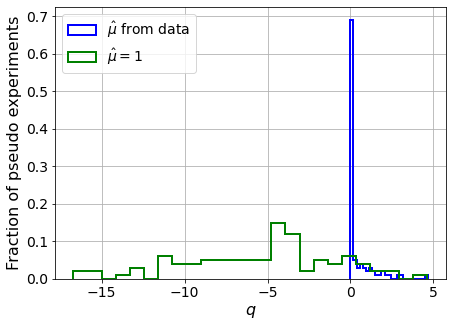

BP3
muhat mean:  0.11900000000000001
Z_MLL:  0.11763006695470878
std Z_MLL:  3.3692379186689574
Z_MLL mu=1:  2.147152968165844
std Z_MLL mu=1:  1.029305937910135
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

3:10000


/tmp/ipykernel_1319836/2262581457.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0037583749612685553
0.0037583749612685553
B_expected:  147986
S_expected:  216

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


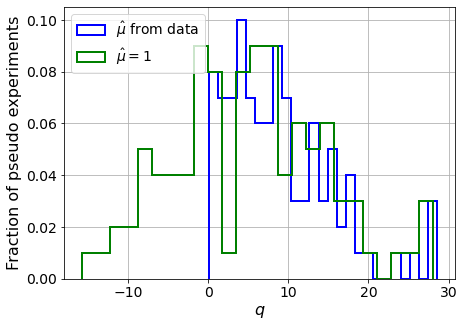

BP4
muhat mean:  0.6160000000000001
Z_MLL:  2.827488750516999
std Z_MLL:  1.1463834574761982
Z_MLL mu=1:  2.4212710712575776
std Z_MLL mu=1:  1.9620554298867505
Z_MLL new:  1.3909449534117877
std Z_MLL new:  1.3629578980786137

--------

4:10000
3 done
4 done
0.003749518576296366
0.003749518576296366
B_expected:  147986
S_expected:  83

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


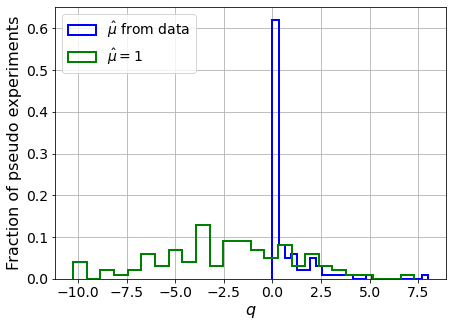

BP5
muhat mean:  0.2535
Z_MLL:  0.24357415539241903
std Z_MLL:  2.5712652913043135
Z_MLL mu=1:  1.4854970649012207
std Z_MLL mu=1:  1.1649383904301986
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

5:10000


/tmp/ipykernel_1319836/2262581457.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.0031820666020015037
0.0031820666020015037
B_expected:  147986
S_expected:  136

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


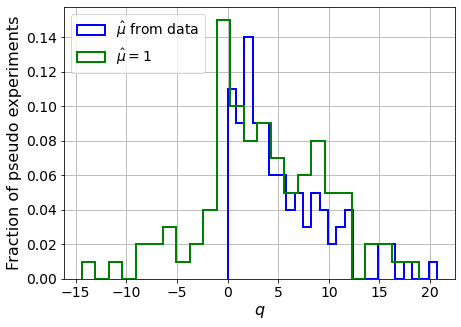

BP6
muhat mean:  0.6910000000000001
Z_MLL:  1.981654339844405
std Z_MLL:  1.1223692477359348
Z_MLL mu=1:  1.7594797387390542
std Z_MLL mu=1:  1.7375390455932824
Z_MLL new:  0.8690947833472745
std Z_MLL new:  1.55665879726226

--------

6:10000
3 done
4 done
0.003613903737061182
0.003613903737061182
B_expected:  147986
S_expected:  40

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


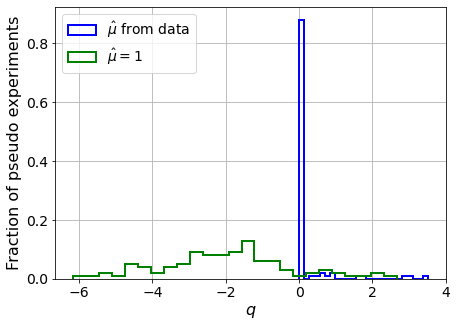

BP7
muhat mean:  0.09050000000000004
Z_MLL:  0.0
std Z_MLL:  inf
Z_MLL mu=1:  1.3934697408866719
std Z_MLL mu=1:  0.6260442709294785
Z_MLL new:  0.0
std Z_MLL new:  inf

--------

7:10000


/home/martinrios/martin/trabajos/MLLHC/codes/AUX_MLL_BL.py:1114: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
/tmp/ipykernel_1319836/2262581457.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


3 done
4 done
0.00297743140707655
0.00297743140707655
B_expected:  147986
S_expected:  77

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


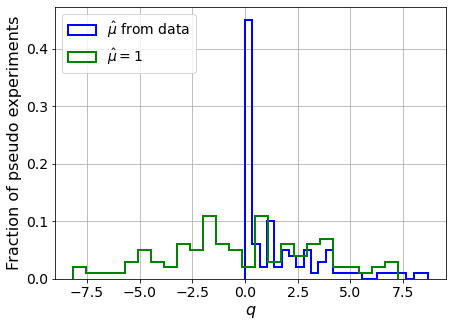

BP8
muhat mean:  0.532
Z_MLL:  0.802529193574098
std Z_MLL:  1.2868313063659222
Z_MLL mu=1:  0.4193304806458354
std Z_MLL mu=1:  4.193293526023471
Z_MLL new:  0.0
std Z_MLL new:  inf

--------



/tmp/ipykernel_1319836/2262581457.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])


In [196]:
D_or_E = "discovery"

Z_MLL_BPs = np.ones(8) * (-99)
Z_MLL_std_BPs = np.ones(8) * (-99)
Z_MLL_BPs_new = np.ones(8) * (-99)
Z_MLL_std_BPs_new = np.ones(8) * (-99)
muhat_MLL = np.ones(8) * (-99)
muhat_MLL_new = np.ones(8) * (-99)

BPS_analyzed = [0,1,2,3,4,5,6,7]
for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))

    print('B_expected: ', int(B_expected))
    print('S_expected: ', int(S_expected[bp]))
    print('')

    Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100, pred_XG_SM = pred_XG_SM, pred_XG_NP = pred_XG_NP)
    #Z_MLL = MLL_test_fsolve(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo, path = '../graph/BP' + str(bp+1) + '/')

    Z_MLL_BPs[bp] = Z_MLL[0]
    Z_MLL_std_BPs[bp] = Z_MLL[1]
    muhat_MLL[bp] = Z_MLL[2]
    
    Z_MLL_BPs_new[bp] = abs( np.median(Z_MLL[6]) )**0.5
    Z_MLL_std_BPs_new[bp] = np.std(Z_MLL[6]) / (2.*Z_MLL_BPs_new[bp])
    
    muhat_MLL_new[bp] = np.mean(Z_MLL[5])
    print('BP' + str(bp+1))
    print('muhat mean: ', Z_MLL[2])
    print('Z_MLL: ', Z_MLL[0])
    print('std Z_MLL: ', Z_MLL[1])
    print('Z_MLL mu=1: ', Z_MLL[3])
    print('std Z_MLL mu=1: ', Z_MLL[4])
    print('Z_MLL new: ', Z_MLL_BPs_new[bp])
    print('std Z_MLL new: ', Z_MLL_std_BPs_new[bp])
    print('')
    print('--------\n')

(array([7.70000e+01, 4.20000e+03, 4.38720e+04, 1.14263e+05, 1.23374e+05,
        8.13980e+04, 4.86780e+04, 2.04470e+04, 2.57300e+03, 1.59000e+02]),
 array([-3.1858566 , -2.1816165 , -1.1773764 , -0.17313626,  0.83110386,
         1.835344  ,  2.839584  ,  3.8438241 ,  4.8480644 ,  5.8523045 ,
         6.8565445 ], dtype=float32),
 <BarContainer object of 10 artists>)

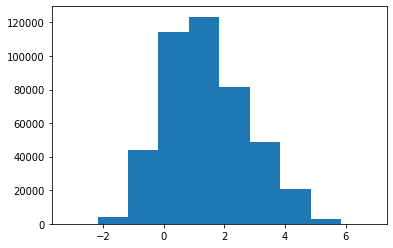

In [197]:
plt.hist(np.log10((1-pred_XG_SM)/pred_XG_SM))

(10.0, 100000.0)

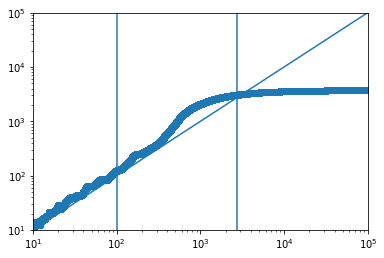

In [198]:
plt.scatter( (1-pred_XG_SM)/pred_XG_SM, pB_B_data / pS_B_data)
plt.xscale('log')
plt.yscale('log')
plt.plot([1e-3,1e6],[1e-3,1e6])
plt.axvline(x=2750)
plt.axvline(x=100)
plt.xlim(1e1,1e5)
plt.ylim(1e1,1e5)

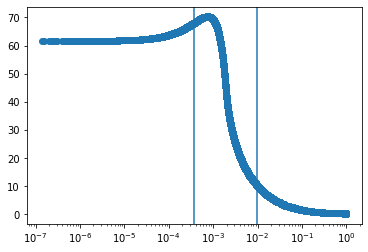

In [199]:
plt.scatter(pred_XG_SM,pB_B_data)
plt.xscale('log')
plt.axvline(x=1/101)
plt.axvline(x=1/2750)

In [200]:
Z_BL_loops.append( Z_BL_BPs )
Z_BL_std_loops.append( Z_BL_std_BPs )
muhat_BL_loops.append( muhat_BL )

Z_MLL_loops.append( Z_MLL_BPs )
Z_MLL_std_loops.append( Z_MLL_std_BPs )
muhat_MLL_loops.append( muhat_MLL )

Z_MLL_new_loops.append( Z_MLL_BPs_new )
Z_MLL_new_std_loops.append( Z_MLL_std_BPs_new )
muhat_MLL_new_loops.append( muhat_MLL_new )

Z_sbc_loops.append( Z_sbc_BPs )
Z_sbc_std_loops.append( Z_sbc_std_BPs )

In [201]:
Z_BL_loops_ar = np.asarray(Z_BL_loops)
Z_BL_std_loops_ar = np.asarray(Z_BL_std_loops)
muhat_BL_loops_ar = np.asarray(muhat_BL_loops)

Z_MLL_loops_ar = np.asarray(Z_MLL_loops)
Z_MLL_std_loops_ar = np.asarray(Z_MLL_std_loops)
muhat_MLL_loops_ar = np.asarray(muhat_MLL_loops)

Z_MLL_new_loops_ar = np.asarray(Z_MLL_new_loops)
Z_MLL_new_std_loops_ar = np.asarray(Z_MLL_new_std_loops)
muhat_MLL_new_loops_ar = np.asarray(muhat_MLL_new_loops)

Z_sbc_loops_ar = np.asarray(Z_sbc_loops)
Z_sbc_std_loops_ar = np.asarray(Z_sbc_std_loops)

In [202]:
np.save('../data/models/Z_BL_MET100_BPI.npy', Z_BL_loops_ar)
np.save('../data/models/Z_BL_std_MET100_BPI.npy', Z_BL_std_loops_ar)
np.save('../data/models/muhat_BL_MET100_BPI.npy', muhat_BL_loops_ar)
np.save('../data/models/Z_MLL_MET100_BPI.npy', Z_MLL_loops_ar)
np.save('../data/models/Z_MLL_std_MET100_BPI.npy', Z_MLL_std_loops_ar)
np.save('../data/models/muhat_MLL_MET100_BPI.npy', muhat_MLL_loops_ar)
np.save('../data/models/Z_MLL_new_MET100_BPI.npy', Z_MLL_new_loops_ar)
np.save('../data/models/Z_MLL_new_std_MET100_BPI.npy', Z_MLL_new_std_loops_ar)
np.save('../data/models/muhat_MLL_new_MET100_BPI.npy', muhat_MLL_new_loops_ar)
np.save('../data/models/Z_sbc_MET100_BPI.npy', Z_sbc_loops_ar)
np.save('../data/models/Z_sbc_std_MET100_BPI.npy', Z_sbc_std_loops_ar)

In [210]:
for i in range(8):
    print('BP' + str(i+1) + ': Z_SBC: ' + str(np.mean(Z_sbc_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.std(Z_sbc_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.mean(Z_sbc_std_loops_ar[10:,:], axis = 0)[i]))
    print('BP' + str(i+1) + ':+ Z_BL: ' + str(np.mean(Z_BL_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.std(Z_BL_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.mean(Z_BL_std_loops_ar[10:,:], axis = 0)[i]))
    print('BP' + str(i+1) + ': Z_MLL: ' + str(np.mean(Z_MLL_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.std(Z_MLL_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.mean(Z_MLL_std_loops_ar[10:,:], axis = 0)[i]))
    print('BP' + str(i+1) + ': Z_new: ' + str(np.mean(Z_MLL_new_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.std(Z_MLL_new_loops_ar[10:,:], axis = 0)[i]) + ' +/- ' + str(np.mean(Z_MLL_new_std_loops_ar[10:,:], axis = 0)[i]))
    print('\n')

BP1: Z_SBC: 1.999256113259482 +/- 0.20016435147730116 +/- 0.22685488097207387
BP1:+ Z_BL: 5.777926023878551 +/- 0.017977476870447914 +/- 0.7941631762245667
BP1: Z_MLL: 6.61431741178086 +/- 0.6666644305571388 +/- 1.0570873513101389
BP1: Z_new: 4.196376247135824 +/- 0.2972951560808071 +/- 1.0876822015004535


BP2: Z_SBC: 0.9766225405795431 +/- 0.10350947799021099 +/- 0.1597549128137007
BP2:+ Z_BL: 3.0015432999848373 +/- 0.06294255010883618 +/- 0.8128891976265432
BP2: Z_MLL: 2.725278014340435 +/- 0.4264458563107449 +/- 1.081153048570345
BP2: Z_new: 0.37975098262403034 +/- 0.1923271433003897 +/- 4.03625585418235


BP3: Z_SBC: 0.35906465409616645 +/- 0.032872724921708285 +/- 0.09871628103609748
BP3:+ Z_BL: 1.0108293843273186 +/- 0.07513247325657064 +/- 1.0081577228128262
BP3: Z_MLL: 0.7595914843211851 +/- 0.39458222109275254 +/- 1.7983683483249373
BP3: Z_new: 0.0 +/- 0.0 +/- inf


BP4: Z_SBC: 1.0473727288394674 +/- 0.08309555640079785 +/- 0.16442192279172418
BP4:+ Z_BL: 3.035226233262103 +/

### Let's try

In [84]:

q_muhat_MLL_mu = []
q_muhat_MLL = []
muhat_selected_MLL_list = []
mu_list = []
q_list = []


B_rand = np.random.poisson(int(B_expected))

ran_ind = np.random.choice(indices_B, B_rand)
pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

pB_B_data_shuf = []
pS_B_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_B_data_shuf.append(pB_B_data[i])
    pS_B_data_shuf.append(pS_B_data[i])

pB_B_data_shuf  = np.array(pB_B_data_shuf)
pS_B_data_shuf  = np.array(pS_B_data_shuf)
        
    
S_rand = np.random.poisson(int(S_expected[bp]))
                
ran_ind = np.random.choice(indices_S, S_rand)
pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

pB_S_data_shuf = []
pS_S_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_S_data_shuf.append(pB_S_data[i])
    pS_S_data_shuf.append(pS_S_data[i])

pB_S_data_shuf  = np.array(pB_S_data_shuf)
pS_S_data_shuf  = np.array(pS_S_data_shuf)                

# p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

# p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
if mu < 0: mu = 0
if mu > 2: mu = 2
mu_list.append(mu)
q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

if np.min(prob_x_given_B) == 0:
    print('There are events with p(s)=0')
    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    print(np.min(prob_x_given_B))

# NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


# ESTIMATE mu_hat for this particular ensemble (implicit equation)
B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

# reference points
sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


# we need (implicit eq. for mu_hat) = 1
# conditions considering the reference points
if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

    muhat_selected_MLL = 2.1

elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

    muhat_selected_MLL = -0.1

elif sum_muhat_zero < 1 < sum_muhat_two:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 > 1:
            muhat_selected_MLL = muhat_test[vv]
            break

elif sum_muhat_two < 1 < sum_muhat_zero:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 < 1:
            muhat_selected_MLL = muhat_test[vv]
            break

muhat_selected_MLL_list.append(muhat_selected_MLL)

# compute the test statistic for each pseudo_exp considering mu_hat
if muhat_selected_MLL > 0:
    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected[bp]) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

else:
    q_muhat_MLL.append( 0 )

There are events with p(s)=0
0.016781813945873785


In [85]:
print('mu:', muhat_selected_MLL)
print('q:', q_muhat_MLL)

mu: -0.1
q: [0]


In [86]:
bp = 3
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

print(str(bp) + ':' + str(len(pred_XG_NP)))
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

print('B_expected: ', int(B_expected))
print('S_expected: ', int(S_expected[bp]))
print('')

3:10000
3 done
4 done
0.0
2.698293741968835e-05
B_expected:  147986
S_expected:  295



In [90]:
muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []
mu_list = []
q_list = []

# loop over the number of pseudo experiments

fail_pseudo = 0
for its in range(num_pseudo):

    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)
    pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

    pB_B_data_shuf = []
    pS_B_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_B_data_shuf.append(pB_B_data[i])
        pS_B_data_shuf.append(pS_B_data[i])

    pB_B_data_shuf  = np.array(pB_B_data_shuf)
    pS_B_data_shuf  = np.array(pS_B_data_shuf)

    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected[bp]))

    ran_ind = np.random.choice(indices_S, S_rand)
    pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

    pB_S_data_shuf = []
    pS_S_data_shuf = []

    # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
    for i in ran_ind:
        pB_S_data_shuf.append(pB_S_data[i])
        pS_S_data_shuf.append(pS_S_data[i])

    pB_S_data_shuf  = np.array(pB_S_data_shuf)
    pS_S_data_shuf  = np.array(pS_S_data_shuf)                

    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

    pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
    mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
    if mu < 0: mu = 0
    if mu > 2: mu = 2
    mu_list.append(mu)
    q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

    if np.min(prob_x_given_B) == 0:
        print('There are events with p(s)=0')
        prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
        print(np.min(prob_x_given_B))

    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

        muhat_selected_MLL = 2.1

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

        muhat_selected_MLL = -0.1

    elif sum_muhat_zero < 1 < sum_muhat_two:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected[bp]) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment
    if 'muhat_selected_MLL' not in locals():
        print('muhat2', sum_muhat_two)
        print('muhat0', sum_muhat_zero)
    muhat_selected_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    if muhat_selected_MLL > 0:
        q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected[bp]) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

    else:
        q_muhat_MLL.append( 0 )

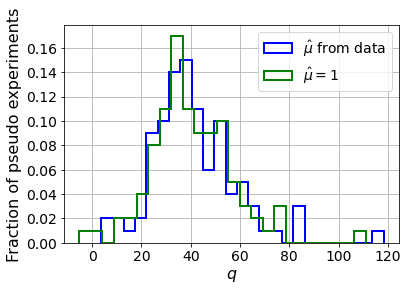

In [91]:
weights = np.ones_like(q_muhat_MLL)/float(len(q_muhat_MLL))
plt.hist(q_muhat_MLL, 25, weights=weights, histtype='step', color='blue', linewidth=2, label=r'$\hat{\mu}$ from data')

weights = np.ones_like(q_muhat_MLL_mu)/float(len(q_muhat_MLL_mu))
plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=1$')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q$",fontsize=16)
plt.ylabel("Fraction of pseudo experiments",fontsize=16)
plt.grid()
plt.legend(fontsize=14)

In [93]:
def MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected, num_pseudo, pred_XG_SM,pred_XG_NP):

	# FIND THE SIGNIFICANCE WITH MLL USING THE TEST STATISTIC FORMALISM (gives statistical error) 
	# Inputs:
		# D_or_E -> statistical test. Options: "exclusion" or "discovery"
		# pB_B_data -> array with BACKGROUND PDF evaluated in each BACKGROUND event,   p_B(background),   shape (len(background), )
		# pS_B_data -> array with SIGNAL PDF evaluated in each BACKGROUND event,       p_B(background),   shape (len(background), )
		# pB_S_data -> array with BACKGROUND PDF evaluated in each SIGNAL event,       p_B(background),   shape (len(signal), )
		# pS_S_data -> array with SIGNAL PDF evaluated in each SIGNAL event,           p_B(background),   shape (len(signal), )
		# B_expected -> number of Background events expected in a pseudo experiment
		# S_expected -> number of Signal events expected in a pseudo experiment
		# num_pseudo -> number of pseudo experiments that are used to compute the test statistic distribution
		
	# Outputs:
		# Z_bins -> value of the significance (using mu_hat that fits the data sample)
		# Z_bins_std -> statistical error (1 sigma) of the significance (using mu_hat that fits the data sample)
		# muhat_mean_bins -> mean of the mu_hat computed from the data sample
		# Z_bins_mu -> value of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
		# Z_bins_std_mu -> statistical error (1 sigma) of the significance (using a FIXED mu_hat=0 for exclusion, mu_hat=1 for discovery)
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]

    if D_or_E == 'discovery':
        indices_S = [i for i in range(len(pS_S_data))]
        
        
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    mu_list = []
    q_list = []
    
    # loop over the number of pseudo experiments
    
    fail_pseudo = 0
    for its in range(num_pseudo):
        
        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)
        
        try:
            if D_or_E == 'exclusion': # only Background events
            
                # p_b(o(x_ensemble)) =  p_b(o(B_ensemble))
                prob_x_given_B = pB_B_data_shuf
    
                # p_s(o(x_ensemble)) =  p_s(o(B_ensemble))
                prob_x_given_S = pS_B_data_shuf
    
                if np.min(prob_x_given_B) == 0:
                    print('There are events with p(s)=0')
                    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    
                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
                # approximation: mu_hat=0 (exclusion)
                q_muhat_MLL_mu.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
                
                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (-0.25) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                
                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_one < 1) or (1 < sum_muhat_one < sum_muhat_zero):
                    
                    muhat_selected_MLL = 1.1
                    
                elif (sum_muhat_one < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_one):
                    
                    muhat_selected_MLL = -0.3
    
                elif sum_muhat_zero < 1 < sum_muhat_one:
                    
                    # grid, mu_hat is around 0
                    muhat_test = np.arange(-0.25, 1., 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
    
                elif sum_muhat_one < 1 < sum_muhat_zero:
                    
                    # grid, mu_hat is around 0
                    muhat_test = np.arange(-0.25, 1., 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
                            
                            
                # save the computed mu_hat (within range) for each pseudo_experiment
                muhat_selected_MLL_list.append(muhat_selected_MLL)
                            
                            
                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 1:
                    q_muhat_MLL.append( 0 )
    
                elif muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( ( (1.-muhat_selected_MLL) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected_MLL*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                else:
                    q_muhat_MLL.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                
                
                
    
    
            if D_or_E == 'discovery': # Background and Signal events
                
                # this pseudo-exp has S_rand number of S events
                S_rand = np.random.poisson(int(S_expected))
                
                ran_ind = np.random.choice(indices_S, S_rand)
                pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]
    
                pB_S_data_shuf = []
                pS_S_data_shuf = []
    
                # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
                for i in ran_ind:
                    pB_S_data_shuf.append(pB_S_data[i])
                    pS_S_data_shuf.append(pS_S_data[i])
    
                pB_S_data_shuf  = np.array(pB_S_data_shuf)
                pS_S_data_shuf  = np.array(pS_S_data_shuf)                
                
                # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
                prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
    
                # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
                prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])
    
                pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
                mu = find_mu(pb_ps_exp, S_expected, B_expected)
                if mu < 0: mu = 0
                if mu > 2: mu = 2
                mu_list.append(mu)
                q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected))

                if np.min(prob_x_given_B) == 0:
                    print('There are events with p(s)=0')
                    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
                    print(np.min(prob_x_given_B))
    
                # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
                # approximation: mu_hat=1 (discovery)
                q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                
                
                # ESTIMATE mu_hat for this particular ensemble (implicit equation)
                B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
                
                # reference points
                sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
                sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                
                # we need (implicit eq. for mu_hat) = 1
                # conditions considering the reference points
                if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                    
                    muhat_selected_MLL = 2.1
                    
                elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                    
                    muhat_selected_MLL = -0.1
    
                elif sum_muhat_zero < 1 < sum_muhat_two:
                    
                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2.05, 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 > 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
    
                elif sum_muhat_two < 1 < sum_muhat_zero:
                    
                    # grid, mu_hat is around 1
                    muhat_test = np.arange(0, 2.05, 0.05)
    
                    for vv in range(len(muhat_test)):
    
                        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                        if mu_hat_condition_equal_1 < 1:
                            muhat_selected_MLL = muhat_test[vv]
                            break
                            
                            
                # save the computed mu_hat (within range) for each pseudo_experiment
                if 'muhat_selected_MLL' not in locals():
                    print('muhat2', sum_muhat_two)
                    print('muhat0', sum_muhat_zero)
                muhat_selected_MLL_list.append(muhat_selected_MLL)
                
                
                # compute the test statistic for each pseudo_exp considering mu_hat
                if muhat_selected_MLL > 0:
                    q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
                else:
                    q_muhat_MLL.append( 0 )
        except:
            fail_pseudo += 1
                
            
    print('Ratio of pseudo experiments that do not satisfied the MIN_EVS condition: ', fail_pseudo/num_pseudo)
    # Histogram of q_muhats
    plt.figure(figsize=(7,5))
    
    weights = np.ones_like(q_muhat_MLL)/float(len(q_muhat_MLL))
    plt.hist(q_muhat_MLL, 25, weights=weights, histtype='step', color='blue', linewidth=2, label=r'$\hat{\mu}$ from data')
    
    weights = np.ones_like(q_muhat_MLL_mu)/float(len(q_muhat_MLL_mu))
    if D_or_E == 'exclusion':
        plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=0$')
    if D_or_E == 'discovery':
        plt.hist(q_muhat_MLL_mu, 25, weights=weights, histtype='step', color='green', linewidth=2, label=r'$\hat{\mu}=1$')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$q$",fontsize=16)
    plt.ylabel("Fraction of pseudo experiments",fontsize=16)
    plt.grid()
    plt.legend(fontsize=14)
    plt.show()
    
    
    
    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)

    Z_MLL = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL_std = np.std(q_muhat_MLL) / (2.*Z_MLL)
    
    
    # With the approximation of mu_hat
    Z_MLL_mu = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_std_mu = np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu)
    
    
    return Z_MLL, Z_MLL_std, muhat_mean_MLL, Z_MLL_mu, Z_MLL_std_mu, mu_list, q_list





Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


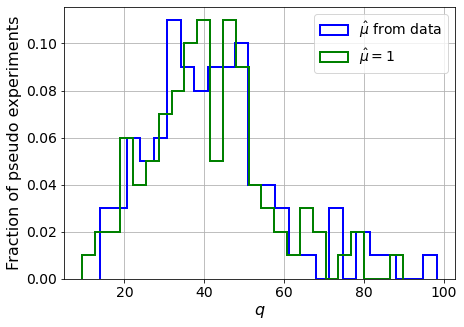

In [94]:
Z_MLL = MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 100,pred_XG_SM=pred_XG_SM,pred_XG_NP=pred_XG_NP)

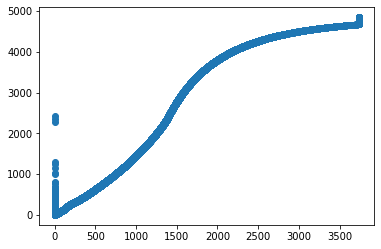

0.5580613340067002
0.10439617397580987
0.10439712693887603


In [81]:
indices_B = [i for i in range(len(pS_B_data))]

indices_S = [i for i in range(len(pS_S_data))]


muhat_selected_MLL_list = []
q_muhat_MLL = []
q_muhat_MLL_mu = []
mu_list = []
q_list = []


# this pseudo-exp has B_rand number of B events
B_rand = np.random.poisson(int(B_expected))

ran_ind = np.random.choice(indices_B, B_rand)
pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

pB_B_data_shuf = []
pS_B_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_B_data_shuf.append(pB_B_data[i])
    pS_B_data_shuf.append(pS_B_data[i])

pB_B_data_shuf  = np.array(pB_B_data_shuf)
pS_B_data_shuf  = np.array(pS_B_data_shuf)

# this pseudo-exp has S_rand number of S events
S_rand = np.random.poisson(int(S_expected[bp]))

ran_ind = np.random.choice(indices_S, S_rand)
pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

pB_S_data_shuf = []
pS_S_data_shuf = []

# for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
for i in ran_ind:
    pB_S_data_shuf.append(pB_S_data[i])
    pS_S_data_shuf.append(pS_S_data[i])

pB_S_data_shuf  = np.array(pB_S_data_shuf)
pS_S_data_shuf  = np.array(pS_S_data_shuf)


# p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

# p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

#%pb_ps_exp = prob_x_given_B / prob_x_given_S
pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])

plt.scatter(pb_ps_exp, prob_x_given_B / prob_x_given_S)
#plt.xscale('log')
#plt.yscale('log')
#%fig,ax = plt.subplots(1,2)
#%ax[0].scatter(pb_ps_B_data, pB_B_data_shuf / pS_B_data_shuf)
#%ax[0].set_xscale('log')
#%ax[0].set_yscale('log')
#%#ax[1].plot([0,400],[0,400])
#%ax[1].scatter(pb_ps_S_data, pB_S_data_shuf / pS_S_data_shuf)
#%#ax[1].plot([0,400],[0,400])
plt.show()

mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
print(mu)
print(find_mu(prob_x_given_B / prob_x_given_S, S_expected[bp], B_expected))
if mu < 0: mu = 0
if mu > 2: mu = 2
mu_list.append(mu)
q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))

if np.min(prob_x_given_B) == 0:
    print('There are events with p(s)=0')
    prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
    print(np.min(prob_x_given_B))

# NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu.append( 2 * ( ( -1. * S_expected[bp]) + sum( [np.log( 1 + ( (1.*S_expected[bp]/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )


# compute mu_hat from implicit equation
def f_mu_hat(mu_h, prob_x_given_B=prob_x_given_B, prob_x_given_S=prob_x_given_S):
    return sum ( [x / ( (x * mu_h * S_expected[bp]) + (y * B_expected) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) - 1


muhat_selected_MLL = fsolve(f_mu_hat,1, xtol=1e-2)[0]
print(muhat_selected_MLL)

Text(0, 0.5, 'KDE')

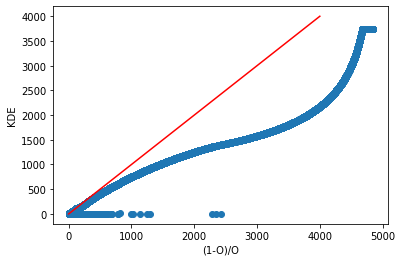

In [82]:
plt.scatter(prob_x_given_B / prob_x_given_S, pb_ps_exp)
#plt.xscale('log')
#plt.yscale('log')
plt.plot([1e-3,4e3],[1e-3,4e3],c = 'red')
plt.xlabel('(1-O)/O')
plt.ylabel('KDE')
#plt.savefig('../graph/comparison_KDE.pdf')

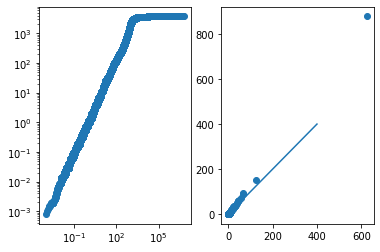

In [189]:
fig,ax = plt.subplots(1,2)

ax[0].scatter((1-pred_XG_SM)/pred_XG_SM, pB_B_data / pS_B_data)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[1].plot([0,400],[0,400])
ax[1].scatter((1-pred_XG_NP)/pred_XG_NP, pB_S_data / pS_S_data)
ax[1].plot([0,400],[0,400])

In [190]:
print(Z_MLL[0], Z_MLL[1])

5.3811970408441665 1.2407660614726699


In [191]:
print(abs( np.median(Z_MLL[8]) )**0.5)

2.693032119628668


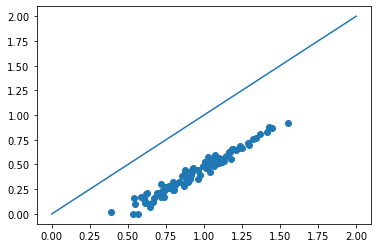

In [192]:
plt.scatter(Z_MLL[5], Z_MLL[7])
plt.plot([0,2],[0,2])

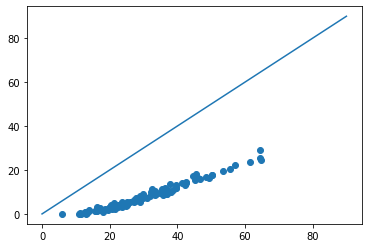

In [193]:
plt.scatter(Z_MLL[6], Z_MLL[8])
plt.plot([0,90],[0,90])

In [118]:
pb_ps_B_data = (1 - pred_XG_SM) / pred_XG_SM
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337

In [116]:
np.max(pB_B_data / pS_B_data)

3736.337703153999

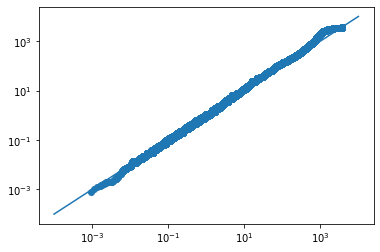

In [119]:
fig,ax = plt.subplots(1,1)

ax.scatter(pb_ps_B_data, pB_B_data / pS_B_data)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(1e-4,1e4)
#ax.set_ylim(1e-4,1e4)
ax.plot([1e-4,1e4], [1e-4,1e4])



In [122]:
start = time.time()

D_or_E = "discovery"

indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

Z_MLL_BPs_new = np.ones(8) * (-99)
Z_MLL_std_BPs_new = np.ones(8) * (-99)
BPS_analyzed = [0,1,2,3,4,5,6,7]

for bp in BPS_analyzed:
    pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == (bp+1))[0]]
    BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
    pred_XG_NP = pred_XG_NP[BP_indices]

    print(str(bp) + ':' + str(len(pred_XG_NP)))
    # FOR DISCOVERY:
    # we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS
    mu_list = []
    q_list = []
    for its in range(100):
        B_rand = np.random.poisson(int(B_expected))
        ran_ind = np.random.choice(indices_B, B_rand)
        pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

        pb_ps_B_data[np.where(pb_ps_B_data > 3736.33)[0]] = 3736.337 # To match previous method

        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)
        pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

        pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
        
        mu = find_mu(pb_ps_exp, S_expected[bp], B_expected)
        if mu < 0: mu = 0
        if mu > 2: mu = 2
        mu_list.append(mu)
        q_list.append(2*(np.sum(np.log( 1 + ( (mu*S_expected[bp]/B_expected) / (pb_ps_exp)))) - mu*S_expected[bp]))


    
    Z_MLL_aux = abs( np.median(q_list) )**0.5
    Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)
    Z_MLL_BPs_new[bp] = Z_MLL_aux
    Z_MLL_std_BPs_new[bp] = Z_MLL_std_aux
    
    print('BP' + str(bp+1))
    print('muhat mean: ', np.mean(mu_list))
    print('Z_MLL: ', Z_MLL_aux)
    print('std Z_MLL: ', Z_MLL_std_aux)
    print('')
    print('--------\n')
    
stop = time.time()
print(f'Last {(stop-start)/60} minutes to perform the MLL')

0:10000
BP1
muhat mean:  0.5442385047467352
Z_MLL:  6.109123444572321
std Z_MLL:  1.2123884367551674

--------

1:10000
BP2
muhat mean:  0.3214808589536529
Z_MLL:  3.6939276760846163
std Z_MLL:  1.1017282297370747

--------

2:10000
BP3
muhat mean:  0.0974402414695244
Z_MLL:  0.18822815395286005
std Z_MLL:  4.5450778118234725

--------

3:10000
BP4
muhat mean:  0.3823396975331739
Z_MLL:  2.6417028317976627
std Z_MLL:  1.0201257683993008

--------

4:10000
BP5
muhat mean:  0.10804492916927216
Z_MLL:  0.06299995003594464
std Z_MLL:  10.900230841905575

--------

5:10000
BP6
muhat mean:  0.3645914169005714
Z_MLL:  1.617844385175915
std Z_MLL:  1.2889051380132766

--------

6:10000


/tmp/ipykernel_1817670/256691188.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  Z_MLL_std_aux = np.std(q_list) / (2.*Z_MLL_aux)


BP7
muhat mean:  0.03924409566239821
Z_MLL:  0.0
std Z_MLL:  inf

--------

7:10000
BP8
muhat mean:  0.20397367896242258
Z_MLL:  0.1450419818870122
std Z_MLL:  5.654111573570895

--------

Last 0.07608150641123454 minutes to perform the MLL


(0.0, 20.0)

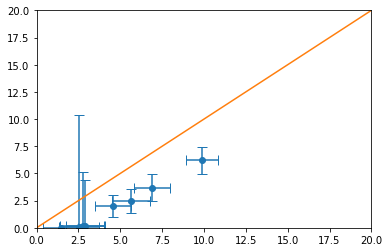

In [120]:
plt.errorbar(Z_MLL_BPs, Z_MLL_BPs_new, xerr=Z_MLL_std_BPs, yerr=Z_MLL_std_BPs_new, fmt='o', capsize=5)
plt.plot([0,20],[0,20])
plt.xlim(0,20)
plt.ylim(0,20)

In [112]:
print(np.min(pB_B_data))
pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
print(np.min(pB_B_data))

0.012822047002307902
0.012822047002307902


In [154]:
pred_XG_NP = y_pred_xg[np.where(df_test_array[:, -1] == 1)[0]]
BP_indices = np.random.choice(np.arange(len(pred_XG_NP)), size = 10000, replace = False)
pred_XG_NP = pred_XG_NP[BP_indices]

In [155]:
pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP

print(np.min(pB_S_data))
pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
print(np.min(pB_S_data))

3 done
4 done
0.001973469036674877
0.001973469036674877


In [156]:
pb_ps_S_data = (1 - pred_XG_NP) / pred_XG_NP

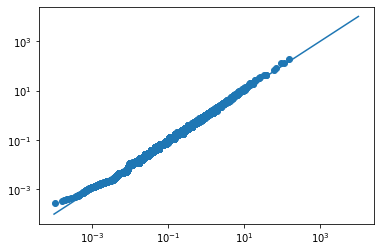

In [157]:
plt.scatter(pb_ps_S_data, pB_S_data / pS_S_data)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [132]:
indices_B = np.arange(len(pS_B_data))
indices_S = np.arange(len(pS_S_data))

In [147]:
S_expected = S_expected[0]

In [184]:
mu_list = []
q_muhat_new_list = []

q_muhat_MLL_mu_aprox_list = []

muhat_MLL_list = []
q_muhat_MLL_list = []
for its in tqdm(range(100)):
    # this pseudo-exp has B_rand number of B events
    B_rand = np.random.poisson(int(B_expected))

    ran_ind = np.random.choice(indices_B, B_rand)
    pb_ps_B_data = (1 - pred_XG_SM[ran_ind]) / pred_XG_SM[ran_ind]

    pB_B_data_shuf  = pB_B_data[ran_ind]
    pS_B_data_shuf  = pS_B_data[ran_ind]

    # this pseudo-exp has S_rand number of S events
    S_rand = np.random.poisson(int(S_expected))

    ran_ind = np.random.choice(indices_S, S_rand)
    pb_ps_S_data = (1 - pred_XG_NP[ran_ind]) / pred_XG_NP[ran_ind]

    pB_S_data_shuf  = pB_S_data[ran_ind]
    pS_S_data_shuf  = pS_S_data[ran_ind]

    # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
    prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

    # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
    prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])

    pb_ps_exp = np.concatenate([pb_ps_B_data, pb_ps_S_data])
    if np.min(prob_x_given_B) == 0:
        print('There are events with p(s)=0')
        prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])
        print(np.min(prob_x_given_B))

    # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
    mu = find_mu(pb_ps_exp, S_expected, B_expected)
    mu_list.append(mu)
    #%print("Valor de mu:", mu)

    q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
    #%print(q_muhat_new)
    q_muhat_new_list.append(q_muhat_new)
    
    # approximation: mu_hat=1 (discovery)
    q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
    q_muhat_MLL_mu_aprox_list.append(q_muhat_MLL_mu_aprox)
    #%print(q_muhat_MLL_mu_aprox)
    
    # ESTIMATE mu_hat for this particular ensemble (implicit equation)
    B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

    # reference points
    sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


    # we need (implicit eq. for mu_hat) = 1
    # conditions considering the reference points
    if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

        muhat_selected_MLL = 2.1

    elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

        muhat_selected_MLL = -0.1

    elif sum_muhat_zero < 1 < sum_muhat_two:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 > 1:
                muhat_selected_MLL = muhat_test[vv]
                break

    elif sum_muhat_two < 1 < sum_muhat_zero:

        # grid, mu_hat is around 1
        muhat_test = np.arange(0, 2.05, 0.05)

        for vv in range(len(muhat_test)):

            mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            if mu_hat_condition_equal_1 < 1:
                muhat_selected_MLL = muhat_test[vv]
                break


    # save the computed mu_hat (within range) for each pseudo_experiment

    #%print('muhat0', muhat_selected_MLL)
    muhat_MLL_list.append(muhat_selected_MLL)


    # compute the test statistic for each pseudo_exp considering mu_hat
    q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
    #%print(q_muhat_MLL)
    q_muhat_MLL_list.append(q_muhat_MLL)


In [185]:
muhat_mean_MLL = np.mean(muhat_MLL_list)

Z_MLL = abs( np.median(q_muhat_MLL_list) )**0.5
Z_MLL_std = np.std(q_muhat_MLL_list) / (2.*Z_MLL)
print(f'ZMLL: {Z_MLL} $\pm$ {Z_MLL_std} ')

muhat_mean_MLL = np.mean(mu_list)

Z_MLL = abs( np.median(q_muhat_new_list) )**0.5
Z_MLL_std = np.std(q_muhat_new_list) / (2.*Z_MLL)
print(f'Z new: {Z_MLL} $\pm$ {Z_MLL_std} ')

ZMLL: 9.317668003149484 $\pm$ 1.147704000162548 
Z new: 6.447860629854573 $\pm$ 1.163543629839523 


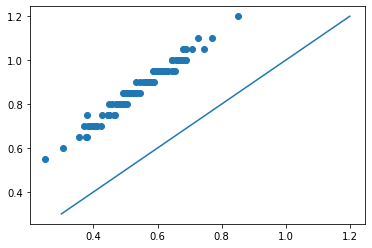

In [186]:
plt.scatter(mu_list, muhat_MLL_list)
plt.plot([0.3,1.2],[0.3,1.2])

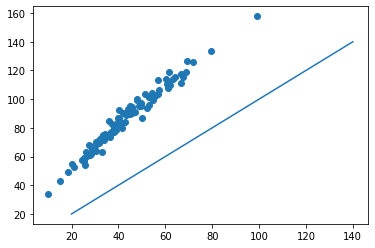

In [187]:
plt.scatter(q_muhat_new_list, q_muhat_MLL_list)
plt.plot([20,140],[20,140])

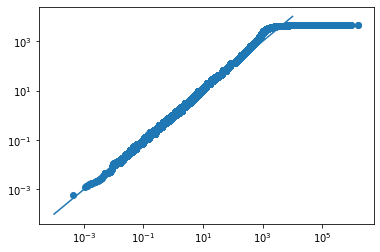

In [160]:
plt.scatter(pb_ps_exp, prob_x_given_B/prob_x_given_S)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-4,1e4)
#plt.ylim(1e-4,1e4)
plt.plot([1e-4,1e4], [1e-4,1e4])

In [172]:
mu = find_mu(pb_ps_exp, S_expected, B_expected)
print("Valor de mu:", mu)

q_muhat_new =  2*(np.sum(np.log( 1 + ( (mu*S_expected/B_expected) / (pb_ps_exp)))) - mu*S_expected)
print(q_muhat_new)

Valor de mu: 0.44645641239308653
24.166161124378277


In [173]:
# approximation: mu_hat=1 (discovery)
q_muhat_MLL_mu_aprox = 2 * ( ( -1. * S_expected) + sum( [np.log( 1 + ( (1.*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) 
print(q_muhat_MLL_mu_aprox)

59.967517429790405


In [163]:
# ESTIMATE mu_hat for this particular ensemble (implicit equation)
B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

# reference points
sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


# we need (implicit eq. for mu_hat) = 1
# conditions considering the reference points
if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):

    muhat_selected_MLL = 2.1

elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):

    muhat_selected_MLL = -0.1

elif sum_muhat_zero < 1 < sum_muhat_two:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 > 1:
            muhat_selected_MLL = muhat_test[vv]
            break

elif sum_muhat_two < 1 < sum_muhat_zero:

    # grid, mu_hat is around 1
    muhat_test = np.arange(0, 2.05, 0.05)

    for vv in range(len(muhat_test)):

        mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

        if mu_hat_condition_equal_1 < 1:
            muhat_selected_MLL = muhat_test[vv]
            break


# save the computed mu_hat (within range) for each pseudo_experiment

print('muhat2', sum_muhat_two)
print('muhat0', sum_muhat_zero)
print(muhat_selected_MLL)


# compute the test statistic for each pseudo_exp considering mu_hat
q_muhat_MLL =  2 * ( (-1.*muhat_selected_MLL * S_expected) + sum( [np.log( 1 + ( (muhat_selected_MLL*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) )
print(q_muhat_MLL)

                

muhat2 0.8961234816352464
muhat0 1.1638868810727716
0.8
63.66409979037803


0:10000
3 done
4 done
0.001721028958048736
0.001721028958048736
B_expected:  147986
S_expected:  641

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


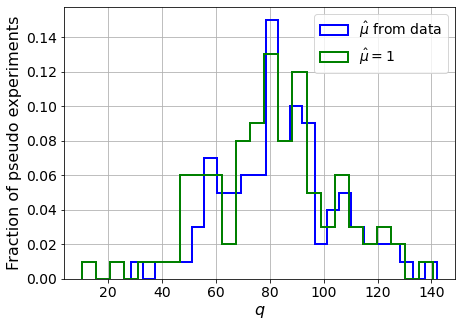

BP1
muhat mean:  0.8634999999999999
Z_MLL:  9.096951076680819
std Z_MLL:  1.138374475447136
Z_MLL mu=1:  8.980095994461541
std Z_MLL mu=1:  1.306797849416438

--------

1:10000
3 done
4 done
0.002030144740528514
0.002030144740528514
B_expected:  147986
S_expected:  582

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


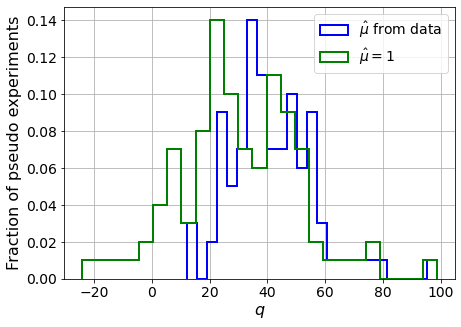

BP2
muhat mean:  0.6470000000000001
Z_MLL:  6.2861269460759335
std Z_MLL:  1.1457998889842997
Z_MLL mu=1:  5.414980994687844
std Z_MLL mu=1:  1.9011878352246527

--------

4:10000
3 done
4 done
0.002073417992791542
0.002073417992791542
B_expected:  147986
S_expected:  177

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


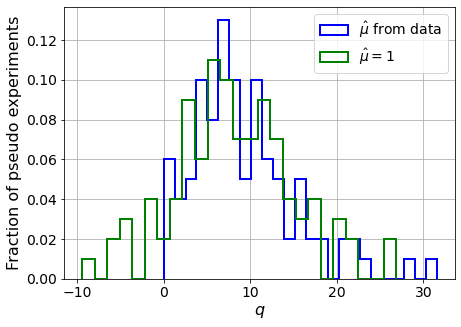

BP5
muhat mean:  0.853
Z_MLL:  2.8424321835072397
std Z_MLL:  1.0670429437461688
Z_MLL mu=1:  2.780341210288127
std Z_MLL mu=1:  1.2305447476669242

--------

7:10000
3 done
4 done
0.001864271943901527
0.001864271943901527
B_expected:  147986
S_expected:  107

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


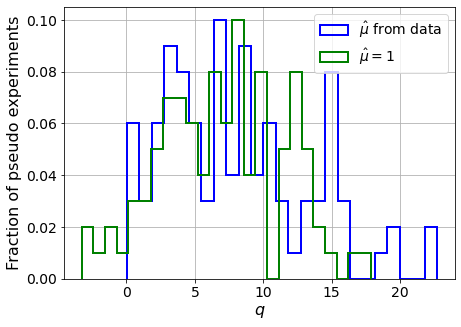

BP8
muhat mean:  1.241
Z_MLL:  2.687331059577332
std Z_MLL:  0.9798436365439029
Z_MLL mu=1:  2.657345857927333
std Z_MLL mu=1:  0.8466127214984356

--------



ValueError: 'a' cannot be empty unless no samples are taken

## Plotting results

In [211]:
ATLAS = np.loadtxt('../../susyatLHC/data/LHC/ATLAS.txt')
CMS   = np.loadtxt('../../susyatLHC/data/LHC/CMS.txt')
DD_bounds = np.loadtxt('../../susyatLHC/data/dd_bound.csv', delimiter=',')

/tmp/ipykernel_1319836/2055490964.py:19: UserWarning: The following kwargs were not used by contour: 'marker'
  contour = plt.contour(xi, yi, zi, levels=[1], alpha=0, colors='blue', linewidths=0, marker='')


(10.0, 40.0)

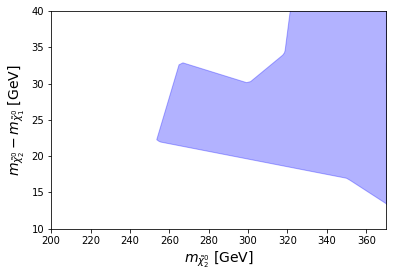

In [212]:
from scipy.interpolate import griddata



x = np.array([200, 200, 200, 250, 250, 250, 300, 300, 300, 300, 350, 350, 350, 350, 400, 400, 400])
y = np.array([34, 19, 10, 37, 22, 13, 40, 39, 24, 15, 41, 26, 17, 10, 43, 27, 18])
f = np.array([0.34, 0.47, 0.09, 0.74, 0.96, 0.19, 0.10, 0.13, 1.6, 0.36, 2.2, 2.5, 1.0, 0.5, 3.2, 3.6, 1.7])


# Creamos una malla regular de puntos (grid) para realizar la interpolación
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)


# Interpolamos los valores f(x, y) en la malla (grid) usando scipy
zi = griddata((x, y), f, (xi, yi), method='linear')

contour = plt.contour(xi, yi, zi, levels=[1], alpha=0, colors='blue', linewidths=0, marker='')

# Extraemos la línea de la curva de nivel f(x,y) = 1
for collection in contour.collections:
    paths = collection.get_paths()
    for path in paths:
        vertices = path.vertices
        x_curve = vertices[:, 0]
        y_curve = vertices[:, 1]
       
plt.fill_betweenx(y_curve, x_curve, 370, alpha=0.3, color='blue')
plt.xlabel(r'$m_{\tilde{\chi}_2^0}$ [GeV]', fontsize=14)
plt.ylabel(r'$m_{\tilde{\chi}_2^0}-m_{\tilde{\chi}_1^0}$ [GeV]', fontsize=14)
plt.xlim(200,370)
plt.ylim(10,40)

In [213]:
mx01_new = np.linspace(150, 300, 30)
mx02_new = np.linspace(160, 310, 30)
mx03_new = np.linspace(160, 320, 30)
mx1_new  = np.linspace(160, 320, 30)

deltam_new = np.linspace(10,25,30)

In [214]:
dm_rd = [2.032, 0.118, 0.016, 1.172, 0.123, 0.026, 0.798, 0.121, 0.035, 0.598, 0.120, 0.044, 0.474, 0.119, 0.052]
i = 0
deltam_min = []
deltam_max = []
dm0_new = []
for i in range(5):
    tck_dm = interpolate.interp1d(x = deltam_new[(i*3):((i+1)*3)], y = dm_rd[(i*3):((i+1)*3)], kind = 'linear', fill_value='extrapolate')
    aux = tck_dm(deltam_new)
    deltam_min.append( deltam_new[np.argmin(np.abs(aux - 0.10))] )
    deltam_max.append( deltam_new[np.argmin(np.abs(aux - 0.14))] )
    dm0_new.append( mx02_new[i*3] )

In [215]:
# Bps
mx01 = np.asarray([151.8, 146.9, 178.2, 187.9, 232.9, 241.9, 282.9, 291.9])
mx02 = np.asarray([163.6, 163.6, 199.6, 199.6, 253.3, 255.1, 305.5, 305.5])
mx03 = np.asarray([170.1, 170.0, 205.6, 205.6, 262.5, 262.0, 312.8, 312.8])
mx1  = np.asarray([167.0, 167.0, 205.8, 205.8, 259.1, 259.1, 310.0, 310.0])

deltam = mx02 - mx01

In [216]:
Z_BL          = np.mean(np.load('../data/models/Z_BL_MET100_BPI.npy')[10:,:], axis = 0)
Z_BL_std      = np.mean(np.load('../data/models/Z_BL_std_MET100_BPI.npy')[10:,:], axis = 0)

Z_MLL         = np.mean(np.load('../data/models/Z_MLL_MET100_BPI.npy')[10:,:], axis = 0)
Z_MLL_std     = np.mean(np.load('../data/models/Z_MLL_std_MET100_BPI.npy')[10:,:], axis = 0)

Z_MLL_new     = np.mean(np.load('../data/models/Z_MLL_new_MET100_BPI.npy')[10:,:], axis = 0)
Z_MLL_new_std = np.mean(np.load('../data/models/Z_MLL_new_std_MET100_BPI.npy')[10:,:], axis = 0)

Z_SBC         = np.mean(np.load('../data/models/Z_sbc_MET100_BPI.npy')[10:,:], axis = 0)
Z_SBC_std     = np.mean(np.load('../data/models/Z_sbc_std_MET100_BPI.npy')[10:,:], axis = 0)

In [217]:
Z_base = S_expected / np.sqrt(B_expected)

In [218]:
dm_planck = 0.12
sd_planck = 0.02

In [219]:
tck_BL   = interpolate.bisplrep(mx02, deltam, Z_BL, kx = 1, ky = 1)
Z_BL_new = interpolate.bisplev(mx02_new, deltam_new, tck_BL)
tck_BL_max   = interpolate.bisplrep(mx02, deltam, (Z_BL + Z_BL_std), kx = 1, ky = 1)
Z_BL_new_max = interpolate.bisplev(mx02_new, deltam_new, tck_BL_max)
tck_BL_min   = interpolate.bisplrep(mx02, deltam, (Z_BL - Z_BL_std), kx = 1, ky = 1)
Z_BL_new_min = interpolate.bisplev(mx02_new, deltam_new, tck_BL_min)

tck_MLL   = interpolate.bisplrep(mx02, deltam, Z_MLL, kx = 1, ky = 1)
Z_MLL_new = interpolate.bisplev(mx02_new, deltam_new, tck_MLL)
tck_MLL_max   = interpolate.bisplrep(mx02, deltam, (Z_MLL + Z_MLL_std), kx = 1, ky = 1)
Z_MLL_new_max = interpolate.bisplev(mx02_new, deltam_new, tck_MLL_max)
tck_MLL_min   = interpolate.bisplrep(mx02, deltam, (Z_MLL - Z_MLL_std), kx = 1, ky = 1)
Z_MLL_new_min = interpolate.bisplev(mx02_new, deltam_new, tck_MLL_min)

tck_SBC   = interpolate.bisplrep(mx02, deltam, Z_SBC, kx = 1, ky = 1)
Z_SBC_new = interpolate.bisplev(mx02_new, deltam_new, tck_SBC)
tck_SBC_max   = interpolate.bisplrep(mx02, deltam, (Z_SBC + Z_SBC_std), kx = 1, ky = 1)
Z_SBC_new_max = interpolate.bisplev(mx02_new, deltam_new, tck_SBC_max)
tck_SBC_min   = interpolate.bisplrep(mx02, deltam, (Z_SBC - Z_SBC_std), kx = 1, ky = 1)
Z_SBC_new_min = interpolate.bisplev(mx02_new, deltam_new, tck_SBC_min)

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=5,5 m=8 fp=nan s=4.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [220]:
from matplotlib.lines import Line2D

/tmp/ipykernel_1319836/204526972.py:3: UserWarning: No contour levels were found within the data range.
  c0 = plt.contour(mx02_new, deltam_new, Z_SBC_new.T, levels = [-1,2,5,16],


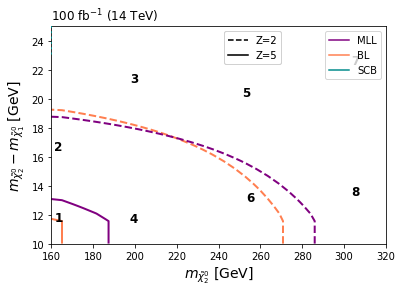

In [222]:
MLL_color = mcolors.to_rgb('purple')

c0 = plt.contour(mx02_new, deltam_new, Z_SBC_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 1, zorder = 4)
#%cm = plt.contour(mx02_new, deltam_new, Z_SBC_new_min.T, levels = [0,2,5,16], 
#%            linestyles = ['dotted','dashed', 'solid'], colors = ['darkcyan'], linewidths = [2], alpha = 0, zorder = 4)

#%f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%plt.fill_between(mx02_new, fm(mx02_new), f0(mx02_new), facecolor ='none', hatch = '|', edgecolor = 'darkcyan', alpha = 1, linewidth = 2, linestyle = '--', zorder = 4)

c0 = plt.contour(mx02_new, deltam_new, Z_BL_new.T, levels = [0,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 1)
#%cM = plt.contour(mx02_new, deltam_new, Z_BL_new_max.T, levels = [0,2,5,16], 
#%            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)
#%cm = plt.contour(mx02_new, deltam_new, Z_BL_new_min.T, levels = [0,2,5,16], 
#%            linestyles = ['dotted','dashed', 'solid'], colors = ['coral'], linewidths = [2], alpha = 0)

#%f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
#%fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#%plt.fill_between(mx02_new, fm(mx02_new), f0(mx02_new), facecolor ='none', hatch ='-', edgecolor = 'coral', alpha = 1, lw = 2)

#%f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%plt.fill_between(mx02_new, fm(mx02_new), np.nan_to_num(f0(mx02_new), neginf = 45, posinf = 45), facecolor = 'none', hatch ='-', edgecolor = 'coral', alpha = 1, linewidth = 2, linestyle = '--')

c0 = plt.contour(mx02_new, deltam_new, Z_MLL_new.T, levels = [-1,2,5,16], 
            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2],alpha=1)
#%cM = plt.contour(mx02_new, deltam_new, Z_MLL_new_max.T, levels = [0,2,5,16], 
#%            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)
#%cm = plt.contour(mx02_new, deltam_new, Z_MLL_new_min.T, levels = [0,2,5,16], 
#%            linestyles = ['dotted','dashed', 'solid'], colors = [MLL_color], linewidths = [2], alpha = 0)

#%f0 = interp1d(c0.allsegs[2][0][:,0], c0.allsegs[2][0][:,1], fill_value = 'extrapolate')
#%fM = interp1d(cM.allsegs[2][0][:,0], cM.allsegs[2][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[2][0][:,0], cm.allsegs[2][0][:,1], fill_value = 'extrapolate')
#%plt.fill_between(mx02_new, fm(mx02_new), f0(mx02_new), facecolor = 'none', edgecolor = MLL_color, hatch='/', alpha = 1, linewidth = 2)

#%f0 = interp1d(c0.allsegs[1][0][:,0], c0.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fM = interp1d(cM.allsegs[1][0][:,0], cM.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%fm = interp1d(cm.allsegs[1][0][:,0], cm.allsegs[1][0][:,1], fill_value = 'extrapolate')
#%plt.fill_between(mx02_new, fm(mx02_new), np.nan_to_num(f0(mx02_new), neginf = 45, posinf = 45), facecolor = 'none', hatch='/', edgecolor = MLL_color, alpha = 1, linewidth = 2, linestyle = '--')


plt.xlabel(r'$m_{\tilde{\chi}_2^0}$ [GeV]', fontsize=14)
plt.ylabel(r'$m_{\tilde{\chi}_2^0}-m_{\tilde{\chi}_1^0}$ [GeV]', fontsize=14)
#plt.grid(True)

line_MLL = Line2D([0], [0], label='MLL', color=MLL_color)
line_BL = Line2D([0], [0], label='BL', color='coral')
line_SCB = Line2D([0], [0], label='SCB', color='darkcyan')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line_MLL, line_BL, line_SCB])
legend0 = plt.legend(handles=handles, loc = 'upper right')
plt.gca().add_artist(legend0)

line_2 = Line2D([0], [0], label='Z=2', color='black', linestyle = 'dashed')
line_5 = Line2D([0], [0], label='Z=5', color='black', linestyle = 'solid')
legend1 = plt.legend([line_2, line_5], ["Z=2", "Z=5"], loc=2, bbox_to_anchor=(0.5,1))
plt.gca().add_artist(legend1)

#ind = np.argsort(ATLAS[:,3])
#plt.fill_betweenx(y = ATLAS[ind,3], x1 = ATLAS[ind,0], color = 'lightgray', alpha = 1)
#ind = np.argsort(CMS[:,3])
#plt.fill_betweenx(y = CMS[ind,3], x1 = CMS[ind,0], color = 'lightgray', alpha = 1)
#plt.text(165, 23, 'LHC exc.', fontsize = 12)

#plt.fill_between(DD_bounds[:,0], DD_bounds[:,1], 41, alpha=0.2, color='blue', zorder = 0)

#plt.scatter(mx02, deltam, c = np.arange(8), cmap = 'viridis')
for i, (xi, yi) in enumerate(zip(mx02, deltam)):
    plt.text(xi, yi, str(i+1), fontsize=12, ha='center', va='center', fontweight='bold')

plt.title('$100$ fb$^{-1}$ (14 TeV)', loc = 'left')
#plt.colorbar()


plt.ylim(10,25)
plt.xlim(160,320)

plt.savefig('../graph/contour_plot_BPI_prel.pdf', bbox_inches="tight")